# Install

In [ ]:
!pip install pytorch-lightning==1.3.8
!pip install wandb
!pip install git+https://github.com/huggingface/transformers
!pip install sentencepiece
!pip install datasets
!pip install tqdm==4.61.1
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 813 kB 5.0 MB/s 
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 319, in run
    reqs, check_supported_wheels=not options.target_dir
  File

# Import and Connect to Drive

In [ ]:
import os
import pandas as pd
import numpy as np
import pickle
import gc
from sklearn.model_selection import train_test_split
import torch.optim as optim
from pytorch_lightning.core.lightning import LightningModule
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable
import wandb
import torchmetrics
import json
import sklearn
from transformers import ReformerTokenizer
from transformers import ReformerConfig
from datasets import Dataset
from transformers import ReformerForSequenceClassification, ReformerModelWithLMHead
from transformers import Trainer, TrainingArguments

ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
os.chdir('gdrive/MyDrive/exp_prot/')

# Preprocessing

In [ ]:
df = pd.read_csv('scop_data.csv')

class_mapping = {"a": 1,"b": 2,"c": 3,"d": 4,"e": 5,"f": 6,"g": 7,"h": 8,"i": 9,"j": 10,"k": 11}
residue_mapping = {"A": 1, "R": 2, "N": 3, "D": 4, "C": 5, "Q": 6, "E": 7, "G": 8, "H": 9, "I": 10, "L": 11, "K": 12, "M": 13, "F": 14, "P": 15, "S": 16, "T": 17, "W": 18, "Y": 19, "V": 20, "X": 0, "O": -1, "B": 21, "Z": 22}
hydophobicity_index = {"A": 0.61, "R": 0.60, "N": 0.06, "D": 0.46, "C": 1.07, "Q": 0., "E": 0.47, "G": 0.07, "H": 0.61, "I": 2.22, "L": 1.53, "K": 1.15, "M": 1.18, "F": 2.02, "P": 1.95, "S": 0.05, "T": 0.05, "W": 2.65, "Y": 1.88, "V": 1.32, "X": -1}

z_1 = {"A": 0.24, "R": 3.52, "N": 3.05, "D": 3.98, "C": 0.84, "Q": 1.75, "E": 3.11, "G": 2.05, "H": 2.47, "I": -3.89, "L": -4.28, "K": 2.29, "M": -2.85, "F": -4.22, "P": -1.66, "S": 2.39, "T": 0.75, "W": -4.36, "Y": -2.54, "V": -2.59, "X": 0, "O": 0}
z_2 = {"A": -2.32, "R": 2.50, "N": 1.62, "D": 0.93, "C": -1.67, "Q": 0.50, "E": 0.26, "G": -4.06, "H": 1.95, "I": -1.73, "L": -1.30, "K": 0.89, "M": -0.22, "F": 1.94, "P": 0.27, "S": -1.07, "T": -2.18, "W": 3.94, "Y": 2.44, "V": -2.64, "X": 0, "O": 0}
z_3 = {"A": 0.60, "R": -3.50, "N": 1.04, "D": 1.93, "C": 3.71, "Q": -1.44, "E": -0.11, "G": 0.36, "H": 0.26, "I": -1.71, "L": -1.49, "K": -2.49, "M": 0.47, "F": 1.06, "P": 1.84, "S": 1.15, "T": -1.12, "W": 0.59, "Y": 0.43, "V": 1.54, "X": 0, "O": 0}
z_4 = {"A": -0.14, "R": 1.99, "N": -1.15, "D": -2.46, "C": 0.18, "Q": -1.34, "E": -3.04, "G": -0.82, "H": 3.90, "I": -0.84, "L": -0.72, "K": 1.49, "M": 1.94, "F": 0.54, "P": 0.70, "S": -1.39, "T": -1.46, "W": 3.44, "Y": 0.04, "V": -0.85, "X": 0, "O": 0}
z_5 = {"A": 1.30, "R": -0.17, "N": 1.61, "D": 0.75, "C": -2.65, "Q": 0.66, "E": -0.25, "G": -0.38, "H": 0.09, "I": 0.26, "L": 0.84, "K": 0.31, "M": -0.98, "F": -0.62, "P": 2.00, "S": 0.67, "T": -0.40, "W": -1.59, "Y": -1.47, "V": -0.02, "X": 0, "O": 0}

for i in z_1:
  print(i,"&",z_1[i],"&",z_2[i],"&",z_3[i],"&",z_4[i],"&",z_5[i],"&",residue_mapping[i],"\\\\")
  print("\hline\hline")

A & 0.24 & -2.32 & 0.6 & -0.14 & 1.3 & 1 \\
\hline\hline
R & 3.52 & 2.5 & -3.5 & 1.99 & -0.17 & 2 \\
\hline\hline
N & 3.05 & 1.62 & 1.04 & -1.15 & 1.61 & 3 \\
\hline\hline
D & 3.98 & 0.93 & 1.93 & -2.46 & 0.75 & 4 \\
\hline\hline
C & 0.84 & -1.67 & 3.71 & 0.18 & -2.65 & 5 \\
\hline\hline
Q & 1.75 & 0.5 & -1.44 & -1.34 & 0.66 & 6 \\
\hline\hline
E & 3.11 & 0.26 & -0.11 & -3.04 & -0.25 & 7 \\
\hline\hline
G & 2.05 & -4.06 & 0.36 & -0.82 & -0.38 & 8 \\
\hline\hline
H & 2.47 & 1.95 & 0.26 & 3.9 & 0.09 & 9 \\
\hline\hline
I & -3.89 & -1.73 & -1.71 & -0.84 & 0.26 & 10 \\
\hline\hline
L & -4.28 & -1.3 & -1.49 & -0.72 & 0.84 & 11 \\
\hline\hline
K & 2.29 & 0.89 & -2.49 & 1.49 & 0.31 & 12 \\
\hline\hline
M & -2.85 & -0.22 & 0.47 & 1.94 & -0.98 & 13 \\
\hline\hline
F & -4.22 & 1.94 & 1.06 & 0.54 & -0.62 & 14 \\
\hline\hline
P & -1.66 & 0.27 & 1.84 & 0.7 & 2.0 & 15 \\
\hline\hline
S & 2.39 & -1.07 & 1.15 & -1.39 & 0.67 & 16 \\
\hline\hline
T & 0.75 & -2.18 & -1.12 & -1.46 & -0.4 & 17 \\
\hline\hl

In [ ]:
df = pd.read_csv('scop_data.csv')

class_mapping = {"a": 1,"b": 2,"c": 3,"d": 4,"e": 5,"f": 6,"g": 7,"h": 8,"i": 9,"j": 10,"k": 11}
residue_mapping = {"A": 1, "R": 2, "N": 3, "D": 4, "C": 5, "Q": 6, "E": 7, "G": 8, "H": 9, "I": 10, "L": 11, "K": 12, "M": 13, "F": 14, "P": 15, "S": 16, "T": 17, "W": 18, "Y": 19, "V": 20, "X": 0, "O": -1, "B": 21, "Z": 22}
hydophobicity_index = {"A": 0.61, "R": 0.60, "N": 0.06, "D": 0.46, "C": 1.07, "Q": 0., "E": 0.47, "G": 0.07, "H": 0.61, "I": 2.22, "L": 1.53, "K": 1.15, "M": 1.18, "F": 2.02, "P": 1.95, "S": 0.05, "T": 0.05, "W": 2.65, "Y": 1.88, "V": 1.32, "X": -1}

z_1 = {"A": 0.24, "R": 3.52, "N": 3.05, "D": 3.98, "C": 0.84, "Q": 1.75, "E": 3.11, "G": 2.05, "H": 2.47, "I": -3.89, "L": -4.28, "K": 2.29, "M": -2.85, "F": -4.22, "P": -1.66, "S": 2.39, "T": 0.75, "W": -4.36, "Y": -2.54, "V": -2.59, "X": 0, "O": 0}
z_2 = {"A": -2.32, "R": 2.50, "N": 1.62, "D": 0.93, "C": -1.67, "Q": 0.50, "E": 0.26, "G": -4.06, "H": 1.95, "I": -1.73, "L": -1.30, "K": 0.89, "M": -0.22, "F": 1.94, "P": 0.27, "S": -1.07, "T": -2.18, "W": 3.94, "Y": 2.44, "V": -2.64, "X": 0, "O": 0}
z_3 = {"A": 0.60, "R": -3.50, "N": 1.04, "D": 1.93, "C": 3.71, "Q": -1.44, "E": -0.11, "G": 0.36, "H": 0.26, "I": -1.71, "L": -1.49, "K": -2.49, "M": 0.47, "F": 1.06, "P": 1.84, "S": 1.15, "T": -1.12, "W": 0.59, "Y": 0.43, "V": 1.54, "X": 0, "O": 0}
z_4 = {"A": -0.14, "R": 1.99, "N": -1.15, "D": -2.46, "C": 0.18, "Q": -1.34, "E": -3.04, "G": -0.82, "H": 3.90, "I": -0.84, "L": -0.72, "K": 1.49, "M": 1.94, "F": 0.54, "P": 0.70, "S": -1.39, "T": -1.46, "W": 3.44, "Y": 0.04, "V": -0.85, "X": 0, "O": 0}
z_5 = {"A": 1.30, "R": -0.17, "N": 1.61, "D": 0.75, "C": -2.65, "Q": 0.66, "E": -0.25, "G": -0.38, "H": 0.09, "I": 0.26, "L": 0.84, "K": 0.31, "M": -0.98, "F": -0.62, "P": 2.00, "S": 0.67, "T": -0.40, "W": -1.59, "Y": -1.47, "V": -0.02, "X": 0, "O": 0}

data_dict={}
for n,i in df.iterrows():
    if '/BREAK/' not in i['SEQUENCE'] and i['SEQUENCE'] != "No fasta files were found.":#selecting single chained proteins
        data_dict[i["PDBID"]] = [class_mapping[i["CLASS"]], i["FOLD"], i["SF"], i["F"], list(i["SEQUENCE"].ljust(2000, 'X'))]
        temp = i["SEQUENCE"]
print(len(list(data_dict.keys())))
# 0-> class, 1-> fold, 2->super family, 3-> family, 4-> sequence
for i in data_dict:
    representation = []
    #print(data_dict[i][4])
    for n, residue in enumerate(data_dict[i][4]):
        residue = residue.upper()
        embedding = []
        if residue == "U":
            residue = "X"
        elif residue == "B" or residue == "Z":
            embedding.append(residue_mapping[residue])
            if residue == "B":
                r_1 = "N"
                r_2 = "D"
            else:
                r_1 = "Q"
                r_2 = "E"
            embedding.append((z_1[r_1]+z_1[r_2])/2)
            embedding.append((z_2[r_1]+z_2[r_2])/2)
            embedding.append((z_3[r_1]+z_3[r_2])/2)
            embedding.append((z_4[r_1]+z_4[r_2])/2)
            embedding.append((z_5[r_1]+z_5[r_2])/2)
            representation.append(embedding)
            continue
        embedding.append(residue_mapping[residue])
        embedding.append(z_1[residue])
        embedding.append(z_2[residue])
        embedding.append(z_3[residue])
        embedding.append(z_4[residue])
        embedding.append(z_5[residue])
        representation.append(np.array(embedding))
    if list(data_dict.keys()).index(i) % 500 == 0:
      #print(list(data_dict.keys()).index(i))
      gc.collect()
    data_dict[i][4] = np.array(representation)
    
with open("embedded_data.pkl", "wb") as fp:
    pickle.dump(data_dict, fp)

69477


In [ ]:
df = pd.read_csv('scop_data.csv')
df2 = pd.DataFrame()
for n,i in df.iterrows():
    if '/BREAK/' not in i['SEQUENCE'] and i['SEQUENCE'] != "No fasta files were found.":#selecting single chained proteins
        df2 = df2.append(i)

In [ ]:
df.groupby('CLASS')['PDBID'].nunique(), df2.groupby('CLASS')['PDBID'].nunique()

(CLASS
 a    16014
 b    22629
 c    23677
 d    18549
 e     1970
 f      868
 g     2250
 h      322
 i      197
 j      592
 k      157
 Name: PDBID, dtype: int64, CLASS
 a    11379
 b    15828
 c    21087
 d    16050
 e     1660
 f      763
 g     1749
 h      236
 i       48
 j      541
 k      136
 Name: PDBID, dtype: int64)

In [ ]:
with open("embedded_data.pkl", "rb") as fp:
  data = pickle.load(fp)

Class

In [ ]:
x=[]
y=[]
max = 0
for i in data:
  x.append(np.asarray(data[i][4]))
  y.append(data[i][0])
x = np.asarray(x)
y = np.asarray(y)
x.shape,y.shape

((69477, 2000, 6), (69477,))

In [ ]:
with open('x.npy', 'wb') as f:
    np.save(f, x)
with open('y.npy', 'wb') as f:
    np.save(f, y)

In [ ]:
with open('x.npy', 'rb') as f:
    x = np.load(f)
    f.close()
with open('y.npy', 'rb') as f:
    y = np.load(f).flatten() - 1
    f.close()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val,  y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [ ]:
with open('x_train.npy', 'wb') as f:
    np.save(f, X_train)
with open('y_train.npy', 'wb') as f:
    np.save(f, y_train)
with open('x_val.npy', 'wb') as f:
    np.save(f, X_val)
with open('y_val.npy', 'wb') as f:
    np.save(f, y_val)
with open('x_test.npy', 'wb') as f:
    np.save(f, X_test)
with open('y_test.npy', 'wb') as f:
    np.save(f, y_test)
f.close()

Fold

In [ ]:
df = pd.read_csv('scop_data.csv')
ranger = range(392)
labels = []
for n,i in df.iterrows():
  labels.append(i.FOLD-1)
for i in ranger:
  if i not in labels:
    print(i)

186
196
301
306
310
314
326
330
332
333
334
340
343
352
376
383
385
388
389


In [ ]:
x=[]
y=[]
max = 0
for i in data:
  if data[i][1] <= 185:
    x.append(np.asarray(data[i][4]))
    y.append(data[i][1])
x = np.asarray(x)
y = np.asarray(y)
x.shape,y.shape

((67955, 2000, 6), (67955,))

In [ ]:
with open('x_fold.npy', 'wb') as f:
    np.save(f, x)
with open('y_fold.npy', 'wb') as f:
    np.save(f, y)

In [ ]:
with open('x_fold.npy', 'rb') as f:
    x = np.load(f)
    f.close()
with open('y_fold.npy', 'rb') as f:
    y = np.load(f).flatten() - 1
    f.close()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val,  y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

ValueError: ignored

In [ ]:
with open('x_train_fold.npy', 'wb') as f:
    np.save(f, X_train)
with open('y_train_fold.npy', 'wb') as f:
    np.save(f, y_train)
with open('x_val_fold.npy', 'wb') as f:
    np.save(f, X_val)
with open('y_val_fold.npy', 'wb') as f:
    np.save(f, y_val)
with open('x_test_fold.npy', 'wb') as f:
    np.save(f, X_test)
with open('y_test_fold.npy', 'wb') as f:
    np.save(f, y_test)
f.close()

# Model

In [ ]:
class ANN(nn.Module):

    """ANN model
    Args:
        nn (nn.Module): nn.Module wrapper.
    """

    def __init__(self, hidden_size = 15, num_layers = 5, dropout = 0.1):

        """
            Args:
                input_parameters (int): number of input parameters
                output_parameters (int): number of output parameters
        """
        super(ANN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = torch.nn.LSTM(input_size = 6,  hidden_size = self.hidden_size, num_layers = self.num_layers,  dropout = self.dropout,  batch_first=True, bidirectional=True)
        self.relu = torch.nn.ReLU()
        self.linear_1 = torch.nn.Linear(2*2000*self.hidden_size, 100)
        self.linear_2 = torch.nn.Linear(100, 11)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        output, _ = self.lstm(input)
        output = self.relu(output)
        output = self.linear_1(output.contiguous().view(-1, 2*2000*self.hidden_size))
        output = self.linear_2(output)
        return output
    
    def forward_2(self, input: torch.Tensor) -> torch.Tensor:
        output, _ = self.lstm(input)
        output = self.relu(output)
        output = self.linear_1(output.contiguous().view(-1, 2*2000*self.hidden_size))
        return output

In [ ]:
class PL_MODULE(pl.LightningModule):
    def __init__(self, data_path = "./", batch_size = 512, learning_rate = 0.0001, number_of_cpus: int = 4, hidden_size = 15, num_layers = 5, dropout = 0.1):
        super(PL_MODULE, self).__init__()
        self.model = ANN(hidden_size, num_layers, dropout)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.number_of_cpus = number_of_cpus
        self.loss = nn.CrossEntropyLoss()
        self.data_path = data_path

        combined_metric = torchmetrics.MetricCollection([torchmetrics.Accuracy(), torchmetrics.Precision(num_classes=11, average='macro'), torchmetrics.F1(num_classes=11, average='macro')])
        self.train_metics = combined_metric.clone()
        self.val_metics = combined_metric.clone()
        self.test_metics = combined_metric.clone()
        self.confmat = torchmetrics.ConfusionMatrix(num_classes=11)



    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Forward step in the model
        Args:
            input (torch.Tensor): input tensor for forward step
        Returns:
            torch.Tensor: prediction tensor after forward step
        """
        return self.model(input)
    
    def train_dataloader(self) -> torch.utils.data.DataLoader:
        """Converts training data to tensor and inserts into DataLoader
        Returns:
            torch.utils.data.DataLoader: DataLoader with training data
        """
        with open(self.data_path + 'x_train.npy', 'rb') as f:
            X_train = np.load(f)
            f.close()
        with open(self.data_path + 'y_train.npy', 'rb') as f:
            y_train = np.load(f).flatten()
            f.close()
        tensor_x_train = Variable(torch.from_numpy(X_train.astype(float))).type(torch.FloatTensor)
        tensor_y_train = Variable(torch.from_numpy(y_train.astype(int))).type(torch.torch.LongTensor).flatten()
        train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=self.batch_size,
            num_workers=self.number_of_cpus,
            pin_memory=True,
        )
        return train_loader

    def val_dataloader(self) -> torch.utils.data.DataLoader:
        """Converts validation data to tensor and inserts into DataLoader
        Returns:
            torch.utils.data.DataLoader: DataLoader with validation data
        """
        with open(self.data_path + 'x_val.npy', 'rb') as f:
            X_val = np.load(f)
            f.close()
        with open(self.data_path + 'y_val.npy', 'rb') as f:
            y_val = np.load(f).flatten()
            f.close()
        tensor_x_validation = Variable(torch.from_numpy(X_val.astype(float))).type(torch.FloatTensor)
        tensor_y_validation = Variable(torch.from_numpy(y_val.astype(int))).type(torch.LongTensor).flatten()
        val_dataset = TensorDataset(tensor_x_validation, tensor_y_validation)
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=self.batch_size,
            num_workers=self.number_of_cpus,
            pin_memory=True,
        )
        return val_loader

    def test_dataloader(self) -> torch.utils.data.DataLoader:
        """Converts test data to tensor and inserts into DataLoader
        Returns:
            torch.utils.data.DataLoader: DataLoader with test data
        """
        with open(self.data_path + 'x_test.npy', 'rb') as f:
            X_test = np.load(f)
            f.close()
        with open(self.data_path + 'y_test.npy', 'rb') as f:
            y_test = np.load(f).flatten()
            f.close()
        tensor_x_test = Variable(torch.from_numpy(X_test.astype(float))).type(torch.FloatTensor)
        tensor_y_test = Variable(torch.from_numpy(y_test.astype(int))).type(torch.LongTensor).flatten()
        
        test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
        test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=self.batch_size,
            num_workers=self.number_of_cpus,
            pin_memory=True,
        )
        return test_loader

    def configure_optimizers(self) -> torch.optim.Adam:
        """Configures and returns the optimizer
        Returns:
            torch.optim.Adam: Adams optimizer
        """
        return optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, train_batch:torch.FloatTensor, batch_idx:int):
        '''
        Returns a dictionary with two indices-
        loss - RMSE loss for the training step
        difference - difference between predicted and output label used to calculate RMSE loss for epoch later.
        '''
        x, y = train_batch
        logits = self.forward(x)
        #y = y.unsqueeze(1)
        loss = self.loss(logits, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("training_scores",self.train_metics(logits.argmax(dim=1), y), on_step = False, on_epoch = True)
        return {'loss':loss, 'logits': logits, 'y': y}

    #def training_epoch_end(self, training_outputs) -> None:
    #    '''
    #    Calculates RMSE loss for the epoch
    #    '''
    #    with torch.no_grad():
    #      self.log("training_accuracy", torch.mean(torch.tensor([self.acc(x["logits"].argmax(dim=1), x["y"]) for x in training_outputs])))
    #      self.log("train_loss_epoch", torch.mean(torch.tensor([self.loss(x["logits"], x["y"]) for x in training_outputs])))

    def validation_step(self, val_batch:torch.FloatTensor, batch_idx:int):
        '''
        Returns a dictionary with two indices-
        loss - RMSE loss for the validation step
        difference - difference between predicted and output label          used to calculate RMSE loss for epoch later.
        '''
        x, y = val_batch
        logits = self.forward(x)
        #y = y.unsqueeze(1)
        loss = self.loss(logits, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("validation_scores",self.val_metics(logits.argmax(dim=1), y), on_step = False, on_epoch = True)
        return {'loss':loss, 'logits': logits, 'y': y}

    #def validation_epoch_end(self, validation_outputs) -> None:
    #    '''
    #    Calculates RMSE loss for the epoch
    #    '''
    #    with torch.no_grad():
    #      self.log("validation_accuracy", torch.mean(torch.tensor([self.acc(x["logits"].argmax(dim=1), x["y"]) for x in validation_outputs])))
    #      self.log("validation_loss_epoch", torch.mean(torch.tensor([self.loss(x["logits"], x["y"]) for x in validation_outputs])))

    def test_step(self, test_batch:torch.FloatTensor, batch_idx:int):       
        '''
        Returns a dictionary with two indices-
        loss - RMSE loss for the testing step
        difference - difference between predicted and output label used to calculate RMSE loss for epoch later.
        '''
        x, y = test_batch
        logits = self.forward(x)
        #y = y.unsqueeze(1)
        loss = self.loss(logits, y.long())
        self.log("test_loss", loss, on_epoch = True, on_step = False)
        self.log("testing_scores",self.test_metics(logits.argmax(dim=1), y), on_step = False, on_epoch = True)
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs = None, y_true = logits.argmax(dim=1).cpu().numpy(), preds = y.cpu().numpy())})
        return {'loss':loss, 'logits': logits, 'y': y}

    #def test_epoch_end(self, test_outputs) -> None:
    #    '''
    #    Calculates RMSE loss for the epoch
    #    '''
    #    with torch.no_grad():
    #      self.log("test_accuracy", torch.mean(torch.tensor([self.acc(x["logits"].argmax(dim=1), x["y"]) for x in test_outputs])))
    #      self.log("test_loss_epoch", torch.mean(torch.tensor([self.loss(x["logits"], x["y"]) for x in test_outputs])))

# Run Model

In [ ]:
gc.collect()

50

In [ ]:
model = PL_MODULE(hidden_size = 50, learning_rate = 0.0001, num_layers = 5, batch_size = 128)   

In [ ]:
wandb_project = "exp_prot"
wandb_run_id = "basic_50_l5_dimS_bi_2"
wandb_logger = pl.loggers.WandbLogger(name = wandb_run_id, project = wandb_project)
checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(dirpath = wandb_project + '/' + wandb_run_id + '/checkpointss',monitor="val_loss",verbose=True,save_top_k=1,save_weights_only=True,mode="min",period=1, save_last=True)

In [ ]:
#trainer = pl.Trainer(max_epochs = 50, gpus = 1, logger = wandb_logger, callbacks=[checkpoint_callback])
trainer = pl.Trainer(max_epochs = 50, gpus = 1,callbacks=[checkpoint_callback])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | model        | ANN              | 20.3 M
1 | loss         | CrossEntropyLoss | 0     
2 | train_metics | MetricCollection | 0     
3 | val_metics   | MetricCollection | 0     
4 | test_metics  | MetricCollection | 0     
5 | confmat      | ConfusionMatrix  | 0     
--------------------------------------------------
20.3 M    Trainable params
0         Non-trainable params
20.3 M    Total params
81.070    Total estimated model params size (MB)


Epoch 0, global step 265: val_loss reached 1.28385 (best 1.28385), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=0-step=265.ckpt" as top 1


Epoch 1, global step 531: val_loss reached 1.15365 (best 1.15365), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=1-step=531.ckpt" as top 1


Epoch 2, global step 797: val_loss reached 1.03802 (best 1.03802), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=2-step=797.ckpt" as top 1


Epoch 3, global step 1063: val_loss reached 0.94672 (best 0.94672), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=3-step=1063.ckpt" as top 1


Epoch 4, global step 1329: val_loss reached 0.88025 (best 0.88025), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=4-step=1329.ckpt" as top 1


Epoch 5, global step 1595: val_loss reached 0.82758 (best 0.82758), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=5-step=1595.ckpt" as top 1


Epoch 6, global step 1861: val_loss reached 0.78624 (best 0.78624), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=6-step=1861.ckpt" as top 1


Epoch 7, global step 2127: val_loss reached 0.74982 (best 0.74982), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=7-step=2127.ckpt" as top 1


Epoch 8, global step 2393: val_loss reached 0.72039 (best 0.72039), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=8-step=2393.ckpt" as top 1


Epoch 9, global step 2659: val_loss reached 0.70577 (best 0.70577), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=9-step=2659.ckpt" as top 1


Epoch 10, global step 2925: val_loss reached 0.67732 (best 0.67732), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=10-step=2925.ckpt" as top 1


Epoch 11, global step 3191: val_loss reached 0.65826 (best 0.65826), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=11-step=3191.ckpt" as top 1


Epoch 12, global step 3457: val_loss reached 0.63683 (best 0.63683), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=12-step=3457.ckpt" as top 1


Epoch 13, global step 3723: val_loss reached 0.62745 (best 0.62745), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=13-step=3723.ckpt" as top 1


Epoch 14, global step 3989: val_loss reached 0.60922 (best 0.60922), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=14-step=3989.ckpt" as top 1


Epoch 15, global step 4255: val_loss was not in top 1


Epoch 16, global step 4521: val_loss reached 0.58174 (best 0.58174), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=16-step=4521.ckpt" as top 1


Epoch 17, global step 4787: val_loss was not in top 1


Epoch 18, global step 5053: val_loss reached 0.57909 (best 0.57909), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot/basic_50_l5_dimS_bi_2/checkpointss/epoch=18-step=5053.ckpt" as top 1


Epoch 19, global step 5319: val_loss was not in top 1


Epoch 20, global step 5585: val_loss was not in top 1


Epoch 21, global step 5851: val_loss was not in top 1


Epoch 22, global step 6117: val_loss was not in top 1


Epoch 23, global step 6383: val_loss was not in top 1


Epoch 24, global step 6649: val_loss was not in top 1


Epoch 25, global step 6915: val_loss was not in top 1


Epoch 26, global step 7181: val_loss was not in top 1


Epoch 27, global step 7447: val_loss was not in top 1


Epoch 28, global step 7713: val_loss was not in top 1


Epoch 29, global step 7979: val_loss was not in top 1


Epoch 30, global step 8245: val_loss was not in top 1


Epoch 31, global step 8511: val_loss was not in top 1


Epoch 32, global step 8777: val_loss was not in top 1


Epoch 33, global step 9043: val_loss was not in top 1


Epoch 34, global step 9309: val_loss was not in top 1


Epoch 35, global step 9575: val_loss was not in top 1


Epoch 36, global step 9841: val_loss was not in top 1


Epoch 37, global step 10107: val_loss was not in top 1


Epoch 38, global step 10373: val_loss was not in top 1


Epoch 39, global step 10639: val_loss was not in top 1


Epoch 40, global step 10905: val_loss was not in top 1


Epoch 41, global step 11171: val_loss was not in top 1


Epoch 42, global step 11437: val_loss was not in top 1


Epoch 43, global step 11703: val_loss was not in top 1


Epoch 44, global step 11969: val_loss was not in top 1


Epoch 45, global step 12235: val_loss was not in top 1


Epoch 46, global step 12501: val_loss was not in top 1


Epoch 47, global step 12767: val_loss was not in top 1


Epoch 48, global step 13033: val_loss was not in top 1


Epoch 49, global step 13299: val_loss was not in top 1
Saving latest checkpoint...


In [ ]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8002608418464661,
 'testing_scores': {'Accuracy': tensor(0.8759, device='cuda:0'),
                    'F1': tensor(0.6117, device='cuda:0'),
                    'Precision': tensor(0.6215, device='cuda:0')}}
--------------------------------------------------------------------------------


[{'test_loss': 0.8002608418464661,
  'testing_scores': {'Accuracy': tensor(0.8759, device='cuda:0'),
   'F1': tensor(0.6117, device='cuda:0'),
   'Precision': tensor(0.6215, device='cuda:0')}}]

#Loading

In [ ]:
model = PL_MODULE(hidden_size = 50, learning_rate = 0.0001, num_layers = 5, batch_size = 128)   

In [ ]:
model2 = model.load_from_checkpoint("exp_prot/basic_50_l5_dimS_bi_2/checkpointss/last.ckpt", hidden_size = 50, learning_rate = 0.0001, num_layers = 5, batch_size = 128)

In [ ]:
agos_ants = []
y = []
with open("agos_real.json", "r") as fp:
  temp = json.loads(fp.read())
  for i in temp:
    if i!='1D0W':
      agos_ants.append(i)
      y.append(1)

with open("ants_real.json", "r") as fp:
  temp = json.loads(fp.read())
  for i in temp:
      agos_ants.append(i)
      y.append(0)

In [ ]:
import requests

class_mapping = {"a": 1,"b": 2,"c": 3,"d": 4,"e": 5,"f": 6,"g": 7,"h": 8,"i": 9,"j": 10,"k": 11}
residue_mapping = {"A": 1, "R": 2, "N": 3, "D": 4, "C": 5, "Q": 6, "E": 7, "G": 8, "H": 9, "I": 10, "L": 11, "K": 12, "M": 13, "F": 14, "P": 15, "S": 16, "T": 17, "W": 18, "Y": 19, "V": 20, "X": 0, "O": -1, "B": 21, "Z": 22}
hydophobicity_index = {"A": 0.61, "R": 0.60, "N": 0.06, "D": 0.46, "C": 1.07, "Q": 0., "E": 0.47, "G": 0.07, "H": 0.61, "I": 2.22, "L": 1.53, "K": 1.15, "M": 1.18, "F": 2.02, "P": 1.95, "S": 0.05, "T": 0.05, "W": 2.65, "Y": 1.88, "V": 1.32, "X": -1}

z_1 = {"A": 0.24, "R": 3.52, "N": 3.05, "D": 3.98, "C": 0.84, "Q": 1.75, "E": 3.11, "G": 2.05, "H": 2.47, "I": -3.89, "L": -4.28, "K": 2.29, "M": -2.85, "F": -4.22, "P": -1.66, "S": 2.39, "T": 0.75, "W": -4.36, "Y": -2.54, "V": -2.59, "X": 0, "O": 0}
z_2 = {"A": -2.32, "R": 2.50, "N": 1.62, "D": 0.93, "C": -1.67, "Q": 0.50, "E": 0.26, "G": -4.06, "H": 1.95, "I": -1.73, "L": -1.30, "K": 0.89, "M": -0.22, "F": 1.94, "P": 0.27, "S": -1.07, "T": -2.18, "W": 3.94, "Y": 2.44, "V": -2.64, "X": 0, "O": 0}
z_3 = {"A": 0.60, "R": -3.50, "N": 1.04, "D": 1.93, "C": 3.71, "Q": -1.44, "E": -0.11, "G": 0.36, "H": 0.26, "I": -1.71, "L": -1.49, "K": -2.49, "M": 0.47, "F": 1.06, "P": 1.84, "S": 1.15, "T": -1.12, "W": 0.59, "Y": 0.43, "V": 1.54, "X": 0, "O": 0}
z_4 = {"A": -0.14, "R": 1.99, "N": -1.15, "D": -2.46, "C": 0.18, "Q": -1.34, "E": -3.04, "G": -0.82, "H": 3.90, "I": -0.84, "L": -0.72, "K": 1.49, "M": 1.94, "F": 0.54, "P": 0.70, "S": -1.39, "T": -1.46, "W": 3.44, "Y": 0.04, "V": -0.85, "X": 0, "O": 0}
z_5 = {"A": 1.30, "R": -0.17, "N": 1.61, "D": 0.75, "C": -2.65, "Q": 0.66, "E": -0.25, "G": -0.38, "H": 0.09, "I": 0.26, "L": 0.84, "K": 0.31, "M": -0.98, "F": -0.62, "P": 2.00, "S": 0.67, "T": -0.40, "W": -1.59, "Y": -1.47, "V": -0.02, "X": 0, "O": 0}

encoded_data = []
y=[]
# 0-> class, 1-> fold, 2->super family, 3-> family, 4-> sequence
for num,filename in enumerate(agos_ants):
    embed_seqs=[]
    seq=""
    embed=[]
    link="https://www.rcsb.org/fasta/entry/"+filename+"/download"
    r = requests.get(link, allow_redirects=True)
    r=r.content.decode('utf8').splitlines()
    #print(r)
    for i in r:
        if i[0]!='>':
              seq+= i
    if len(seq) > 2000:
      print(num)
      continue
    else:
      seq = list(seq.ljust(2000, 'X'))
    representation = []
    for n, residue in enumerate(seq):
        residue = residue.upper()
        embedding = []
        if residue == "U":
            residue = "X"
        elif residue == "B" or residue == "Z":
            embedding.append(residue_mapping[residue])
            if residue == "B":
                r_1 = "N"
                r_2 = "D"
            else:
                r_1 = "Q"
                r_2 = "E"
            embedding.append((z_1[r_1]+z_1[r_2])/2)
            embedding.append((z_2[r_1]+z_2[r_2])/2)
            embedding.append((z_3[r_1]+z_3[r_2])/2)
            embedding.append((z_4[r_1]+z_4[r_2])/2)
            embedding.append((z_5[r_1]+z_5[r_2])/2)
            representation.append(embedding)
            continue
        embedding.append(residue_mapping[residue])
        embedding.append(z_1[residue])
        embedding.append(z_2[residue])
        embedding.append(z_3[residue])
        embedding.append(z_4[residue])
        embedding.append(z_5[residue])
        representation.append(np.array(embedding))
    if num < 395:
      y.append(1)
    else:
      y.append(0)
    encoded_data.append(np.asarray(representation))

346
347
348
349
358
547


In [ ]:
x = np.asarray(encoded_data)
y = np.asarray(y)
x.shape,y.shape

((545, 2000, 6), (545,))

In [ ]:
model_outputs = model2.model.forward_2(Variable(torch.from_numpy(x.astype(float))).type(torch.FloatTensor)).cpu().detach().numpy()

In [ ]:
x.shape

(545, 100)

In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score

x = model_outputs

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate,StratifiedKFold

model = AdaBoostClassifier()
# evaluate the model
print("f1",np.mean(cross_val_score(model, x, y,scoring="f1_macro",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("f1",np.mean(cross_val_score(model, x, y,scoring="f1",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("precision",np.mean(cross_val_score(model, x, y,scoring="precision",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("accuracy",np.mean(cross_val_score(model, x, y,scoring="accuracy",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("accuracy",(cross_val_score(model, x, y,scoring="accuracy",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("roc_auc",np.mean(cross_val_score(model, x, y,scoring="roc_auc",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))

f1 0.6680003468964062
f1 0.8300326434773109
precision 0.8051772204274116
accuracy 0.7485521885521886
accuracy [0.81818182 0.78181818 0.67272727 0.74545455 0.76363636 0.68518519
 0.72222222 0.75925926 0.81481481 0.72222222]
roc_auc 0.7280555555555555


# Sweeps not working cuz reinitialization crashes RAM

In [ ]:
sweep_config = {
  "name" : "my-sweep",
  "method" : "random",
  "parameters" : {
    "num_layers" :{
      "min": 1,
      "max": 10
    },
    "hidden_size" :{
      "min": 1,
      "max": 50
    },
    "dropout" :{
      "min": 0,
      "max": 0.5
    },
  }
}
sweep_id = wandb.sweep(sweep_config, project="exp_prot")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. {'max': 0.5, 'min': 0} is not valid under any of the given schemas


Create sweep with ID: 6t7hh0i8
Sweep URL: https://wandb.ai/choke/exp_prot/sweeps/6t7hh0i8


In [ ]:
def train():
    with wandb.init() as run:
        config = wandb.config
        #print(config)
        model = PL_MODULE(hidden_size = config["hidden_size"], learning_rate = 0.0001, num_layers = config["num_layers"])
        wandb_project = "exp_prot"
        wandb_logger = pl.loggers.WandbLogger(project = wandb_project)
        trainer = pl.Trainer(max_epochs = 20, gpus = 1, logger = wandb_logger)
        trainer.fit(model)
        trainer.test(model)
        del model
        gc.collect()


count = 10 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count, project="exp_prot")

wandb: Agent Starting Run: 33g2nm3a with config:
wandb: 	dropout: 0.3766034145855406
wandb: 	hidden_size: 30
wandb: 	num_layers: 4
wandb: Currently logged in as: choke (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | model        | ANN              | 12.1 M
1 | loss         | CrossEntropyLoss | 0     
2 | train_metics | MetricCollection | 0     
3 | val_metics   | MetricCollection | 0     
4 | test_metics  | MetricCollection | 0     
5 | confmat      | ConfusionMatrix  | 0     
--------------------------------------------------
12.1 M    Trainable params
0         Non-trainable params
12.1 M    Total params
48.306    Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5957892537117004,
 'testing_scores': {'Accuracy': tensor(0.8176, device='cuda:0'),
                    'F1': tensor(0.6514, device='cuda:0'),
                    'Precision': tensor(0.6738, device='cuda:0')}}
--------------------------------------------------------------------------------


train_loss_step,0.31075
epoch,49
trainer/global_step,3350
_runtime,4507
_timestamp,1623883106
_step,208
train_loss_epoch,0.42813
val_loss,0.59406
test_loss,0.59579


train_loss_step,█▇▆▅▆▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▃▂▃▃▃▂▂▂▂▂▁▂▂▂▂▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██████████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▇▆▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁


wandb: Agent Starting Run: hbi2tmo3 with config:
wandb: 	dropout: 0.22093385814976207
wandb: 	hidden_size: 24
wandb: 	num_layers: 9


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | model        | ANN              | 9.7 M 
1 | loss         | CrossEntropyLoss | 0     
2 | train_metics | MetricCollection | 0     
3 | val_metics   | MetricCollection | 0     
4 | test_metics  | MetricCollection | 0     
5 | confmat      | ConfusionMatrix  | 0     
--------------------------------------------------
9.7 M     Trainable params
0         Non-trainable params
9.7 M     Total params
38.884    Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7733820676803589,
 'testing_scores': {'Accuracy': tensor(0.7322, device='cuda:0'),
                    'F1': tensor(0.5590, device='cuda:0'),
                    'Precision': tensor(0.6037, device='cuda:0')}}
--------------------------------------------------------------------------------


train_loss_step,0.60006
epoch,49
trainer/global_step,3350
_runtime,10329
_timestamp,1623893447
_step,208
train_loss_epoch,0.72575
val_loss,0.78496
test_loss,0.77338


train_loss_step,██▇▆▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,██▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,██▇▆▆▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
test_loss,▁


wandb: Agent Starting Run: c906tqo1 with config:
wandb: 	dropout: 0.40641318330425596
wandb: 	hidden_size: 28
wandb: 	num_layers: 3


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | model        | ANN              | 11.2 M
1 | loss         | CrossEntropyLoss | 0     
2 | train_metics | MetricCollection | 0     
3 | val_metics   | MetricCollection | 0     
4 | test_metics  | MetricCollection | 0     
5 | confmat      | ConfusionMatrix  | 0     
--------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.991    Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5787408351898193,
 'testing_scores': {'Accuracy': tensor(0.8187, device='cuda:0'),
                    'F1': tensor(0.6508, device='cuda:0'),
                    'Precision': tensor(0.6646, device='cuda:0')}}
--------------------------------------------------------------------------------


train_loss_step,0.2822
epoch,49
trainer/global_step,3350
_runtime,3358
_timestamp,1623896818
_step,208
train_loss_epoch,0.42337
val_loss,0.58202
test_loss,0.57874


train_loss_step,██▆▅▆▅▅▅▄▄▄▄▄▃▄▃▃▃▃▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁


wandb: Agent Starting Run: 13cm8erv with config:
wandb: 	dropout: 0.4001162038894768
wandb: 	hidden_size: 22
wandb: 	num_layers: 10


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | model        | ANN              | 8.9 M 
1 | loss         | CrossEntropyLoss | 0     
2 | train_metics | MetricCollection | 0     
3 | val_metics   | MetricCollection | 0     
4 | test_metics  | MetricCollection | 0     
5 | confmat      | ConfusionMatrix  | 0     
--------------------------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.657    Total estimated model params size (MB)


wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.
wandb: Network error resolved after 0:00:57.102610, resuming normal operation.


wandb: Network error (HTTPError), entering retry loop.
wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.
wandb: Network error (HTTPError), entering retry loop.
wandb: Network error (HTTPError), entering retry loop.
wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.
wandb: Network error (HTTPError), entering retry loop.
wandb: Network error (HTTPError), entering retry loop.


wandb: 500 encountered ({"error":"Error 1040: Too many connections"}), retrying request
wandb: Network error resolved after 0:09:33.516698, resuming normal operation.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8512604236602783,
 'testing_scores': {'Accuracy': tensor(0.6991, device='cuda:0'),
                    'F1': tensor(0.5298, device='cuda:0'),
                    'Precision': tensor(0.5596, device='cuda:0')}}
--------------------------------------------------------------------------------


train_loss_step,0.70442
epoch,49
trainer/global_step,3350
_runtime,11435
_timestamp,1623908266
_step,208
train_loss_epoch,0.80907
val_loss,0.85935
test_loss,0.85126


train_loss_step,██▇▆▇▆▆▆▅▅▅▄▄▄▄▄▄▃▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,██▇▆▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,██▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
test_loss,▁


wandb: Agent Starting Run: 58frcr4z with config:
wandb: 	dropout: 0.08982665609209733
wandb: 	hidden_size: 28
wandb: 	num_layers: 3


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | model        | ANN              | 11.2 M
1 | loss         | CrossEntropyLoss | 0     
2 | train_metics | MetricCollection | 0     
3 | val_metics   | MetricCollection | 0     
4 | test_metics  | MetricCollection | 0     
5 | confmat      | ConfusionMatrix  | 0     
--------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.991    Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5904120802879333,
 'testing_scores': {'Accuracy': tensor(0.8202, device='cuda:0'),
                    'F1': tensor(0.6525, device='cuda:0'),
                    'Precision': tensor(0.6713, device='cuda:0')}}
--------------------------------------------------------------------------------


train_loss_step,0.3292
epoch,49
trainer/global_step,3350
_runtime,3246
_timestamp,1623911525
_step,208
train_loss_epoch,0.41131
val_loss,0.59331
test_loss,0.59041


train_loss_step,██▆▅▆▅▅▅▄▄▄▄▃▃▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁


wandb: Agent Starting Run: f6e5mamw with config:
wandb: 	dropout: 0.45503481865775136
wandb: 	hidden_size: 13
wandb: 	num_layers: 8


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | model        | ANN              | 5.2 M 
1 | loss         | CrossEntropyLoss | 0     
2 | train_metics | MetricCollection | 0     
3 | val_metics   | MetricCollection | 0     
4 | test_metics  | MetricCollection | 0     
5 | confmat      | ConfusionMatrix  | 0     
--------------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.933    Total estimated model params size (MB)


wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.9430848360061646,
 'testing_scores': {'Accuracy': tensor(0.6627, device='cuda:0'),
                    'F1': tensor(0.4616, device='cuda:0'),
                    'Precision': tensor(0.5141, device='cuda:0')}}
--------------------------------------------------------------------------------


train_loss_step,0.80762
epoch,49
trainer/global_step,3350
_runtime,8263
_timestamp,1623919803
_step,208
train_loss_epoch,0.92361
val_loss,0.93892
test_loss,0.94308


train_loss_step,███▆▇▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▃▃▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,███▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,███▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
test_loss,▁


wandb: Agent Starting Run: 0t09th6t with config:
wandb: 	dropout: 0.371749878626246
wandb: 	hidden_size: 30
wandb: 	num_layers: 5


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | model        | ANN              | 12.1 M
1 | loss         | CrossEntropyLoss | 0     
2 | train_metics | MetricCollection | 0     
3 | val_metics   | MetricCollection | 0     
4 | test_metics  | MetricCollection | 0     
5 | confmat      | ConfusionMatrix  | 0     
--------------------------------------------------
12.1 M    Trainable params
0         Non-trainable params
12.1 M    Total params
48.395    Total estimated model params size (MB)


# Transformer Data Preprocess

In [ ]:
!wandb enabled
os.environ["WANDB_DISABLED"] = "false"

W&B enabled.


In [ ]:
wandb.login()
!WANDB_PROJECT=prot_reformer

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
df = pd.read_csv('scop_data.csv')

sequences = []
labels = []
df_clean = pd.DataFrame()
for n, i in df.iterrows():
  if '/BREAK/' not in i['SEQUENCE'] and i['SEQUENCE'] != "No fasta files were found.":#selecting single chained proteins
    sequences.append(i.SEQUENCE)
    labels.append(class_mapping[i.CLASS])
    df_clean = df_clean.append(i)

NameError: ignored

In [ ]:
df_clean.to_csv("scop_data_clean.csv", index=False)

In [ ]:
with open("sequences_scope.txt", "w") as fp:
  for i in sequences:
    fp.write(i+"\n")

In [ ]:
with open("sequences_class_scope.csv", "w") as fp:
  fp.write("idx,sequence,labels\n")
  for n,i in enumerate(sequences):
    fp.write(str(n)+","+i+","+str(labels[n])+"\n")

In [ ]:
from transformers import ReformerTokenizer
import sentencepiece as spm

spm.SentencePieceTrainer.train(input='./sequences_scope.txt', model_prefix='pREFORMo', max_sentence_length=4095, vocab_size=25)

In [ ]:
from sklearn.model_selection import train_test_split

df_clean = pd.read_csv("scop_data_clean.csv")

df_train, df_test = train_test_split(df_clean, test_size=0.2, random_state = 0)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state = 0)

df_train.to_csv("scop_data_clean_train.csv", index=False)
df_test.to_csv("scop_data_clean_test.csv", index=False)
df_val.to_csv("scop_data_clean_val.csv", index=False)

# Params

In [ ]:
max_length = 2048
num_attention_heads = 30
num_hidden_layers = 12

# Transformer Utils

In [ ]:
df_train = pd.read_csv("scop_data_clean_train.csv")
df_test = pd.read_csv("scop_data_clean_test.csv")
df_val = pd.read_csv("scop_data_clean_val.csv")

class_mapping = {"a": 0,"b": 1,"c": 2,"d": 3,"e": 4,"f": 5,"g": 6, "h": 7, "i": 8,"j": 9,"k": 10}
num_labels=len(class_mapping)

data_dict_train = {'sequences':[], 'labels':[]}
for n, i in df_train.iterrows():
  if '/BREAK/' not in i['SEQUENCE'] and i['SEQUENCE'] != "No fasta files were found.":#selecting single chained proteins
    data_dict_train['sequences'].append(i.SEQUENCE)
    data_dict_train['labels'].append([class_mapping[i.CLASS]])

data_dict_test = {'sequences':[], 'labels':[]}
for n, i in df_test.iterrows():
  if '/BREAK/' not in i['SEQUENCE'] and i['SEQUENCE'] != "No fasta files were found.":#selecting single chained proteins
    data_dict_test['sequences'].append(i.SEQUENCE)
    data_dict_test['labels'].append([class_mapping[i.CLASS]])

data_dict_val = {'sequences':[], 'labels':[]}
for n, i in df_val.iterrows():
  if '/BREAK/' not in i['SEQUENCE'] and i['SEQUENCE'] != "No fasta files were found.":#selecting single chained proteins
    data_dict_val['sequences'].append(i.SEQUENCE)
    data_dict_val['labels'].append([class_mapping[i.CLASS]])

In [ ]:
class ScopeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val) for key, val in self.encodings[idx].items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
tokenizer = ReformerTokenizer("pREFORMo.model", padding=True)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["sequences"],  max_length = max_length, padding="max_length")

In [ ]:
train_dataset = Dataset.from_dict(data_dict_train)
test_dataset = Dataset.from_dict(data_dict_test)
val_dataset = Dataset.from_dict(data_dict_val)

In [ ]:
labels = train_dataset['labels']
encoded_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["sequences","labels"])
train_dataset = ScopeDataset(encoded_dataset, labels)

labels = test_dataset['labels']
encoded_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=["sequences","labels"])
test_dataset = ScopeDataset(encoded_dataset, labels)

labels = val_dataset['labels']
encoded_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=["sequences","labels"])
val_dataset = ScopeDataset(encoded_dataset, labels)

  0%|          | 0/45 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

# Tranformer Model

In [ ]:
config = ReformerConfig(
    vocab_size=30,
    max_position_embeddings=max_length,
    num_attention_heads=num_attention_heads,
    num_hidden_layers=num_hidden_layers,
    num_labels=11,
    use_cache = False,
    axial_pos_shape = (64,32)
)

In [ ]:
model = ReformerForSequenceClassification(config=config)

In [ ]:
# metrics util function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    label_list = range(11)
    f1_list =  sklearn.metrics.f1_score(labels, preds, labels=list(range(11)), average=None)
    recall_list =  sklearn.metrics.recall_score(labels, preds, labels=list(range(11)), average=None)

    result_dict = {}
    #result_dict.update({f'f1_{label_list[i]}': score for i, score in enumerate(f1_list)})
    #result_dict.update({f'recall_{label_list[i]}': score for i, score in enumerate(recall_list)})
    result_dict['acc'] = sklearn.metrics.accuracy_score(labels, preds)
    result_dict['bac'] = sklearn.metrics.balanced_accuracy_score(labels, preds)
    result_dict['mcc'] = sklearn.metrics.matthews_corrcoef(labels, preds)
    result_dict['f1_macro'] = sklearn.metrics.f1_score(labels, preds, average='macro')
        
    return result_dict

In [ ]:
training_args = TrainingArguments(
    output_dir="./pREFORMo",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size = 32,
    save_steps=10_000,
    save_total_limit=2,
    evaluation_strategy = "epoch",
    report_to="wandb",
    run_name=f"num_attention_heads_{num_attention_heads}_num_hidden_layers_{num_hidden_layers}"
)

trainer = Trainer(
    model=model,
    args=training_args,
    #data_collator=data_collator,
    train_dataset=train_dataset,
    #test_dataset=test_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()
train_result = trainer.state.log_history[-1]
train_result

***** Running training *****
  Num examples = 44464
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 13900
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.7/dist-packages/transformers/models/reformer/modeling_reformer.py:1164: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorCompare.cpp:255.)
  query_key_dots = torch.where(mask, query_key_dots, mask_value)
config.num_buckets is not set. Setting config.num_buckets to 64...
config.num_buckets is not set. Setting config.num_buckets to 64...
config.num_buckets is not set. Setting config.num_buckets to 64...


Epoch,Training Loss,Validation Loss,Acc,Bac,Mcc,F1 Macro
1,1.459400,1.432939,0.391203,0.240795,0.194139,0.217901
2,1.427700,1.436022,0.392012,0.248705,0.201285,0.202775
3,1.346800,1.338789,0.434740,0.279209,0.261185,0.259568
4,1.264400,1.200998,0.517766,0.332062,0.370182,0.309917
5,1.190600,1.153616,0.538455,0.323231,0.398975,0.307678
6,1.138800,1.064272,0.597014,0.372523,0.477228,0.360739
7,1.081700,1.054171,0.599442,0.378633,0.480631,0.360514
8,1.054000,1.026880,0.615004,0.394987,0.499007,0.377644
9,1.016200,1.017239,0.616173,0.400049,0.500959,0.397092
10,1.007700,1.008472,0.619951,0.399992,0.505509,0.389252


***** Running Evaluation *****
  Num examples = 11117
  Batch size = 32
***** Running Evaluation *****
  Num examples = 11117
  Batch size = 32
***** Running Evaluation *****
  Num examples = 11117
  Batch size = 32
***** Running Evaluation *****
  Num examples = 11117
  Batch size = 32
***** Running Evaluation *****
  Num examples = 11117
  Batch size = 32
***** Running Evaluation *****
  Num examples = 11117
  Batch size = 32
***** Running Evaluation *****
  Num examples = 11117
  Batch size = 32
Saving model checkpoint to ./pREFORMo/checkpoint-10000
Configuration saved in ./pREFORMo/checkpoint-10000/config.json
Model weights saved in ./pREFORMo/checkpoint-10000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11117
  Batch size = 32
***** Running Evaluation *****
  Num examples = 11117
  Batch size = 32
***** Running Evaluation *****
  Num examples = 11117
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




{'epoch': 10.0,
 'step': 13900,
 'total_flos': 6.58432405241856e+16,
 'train_loss': 1.207785837736061,
 'train_runtime': 50651.102,
 'train_samples_per_second': 8.778,
 'train_steps_per_second': 0.274}

In [ ]:
predictions = trainer.predict(test_dataset)
wandb.log(predictions[2])
predictions[2]

In [ ]:
wandb.finish()

# LM

In [ ]:
config = ReformerConfig(
    vocab_size=30,
    max_position_embeddings=max_length,
    num_attention_heads=num_attention_heads,
    num_hidden_layers=num_hidden_layers,
    use_cache = False,
    axial_pos_shape = (64,32),
    is_decoder=True,
)

In [ ]:
model = ReformerModelWithLMHead(config=config)

In [ ]:
# metrics util function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    label_list = range(11)
    f1_list =  sklearn.metrics.f1_score(labels, preds, labels=list(range(11)), average=None)
    recall_list =  sklearn.metrics.recall_score(labels, preds, labels=list(range(11)), average=None)

    result_dict = {}
    #result_dict.update({f'f1_{label_list[i]}': score for i, score in enumerate(f1_list)})
    #result_dict.update({f'recall_{label_list[i]}': score for i, score in enumerate(recall_list)})
    result_dict['acc'] = sklearn.metrics.accuracy_score(labels, preds)
    result_dict['bac'] = sklearn.metrics.balanced_accuracy_score(labels, preds)
    result_dict['mcc'] = sklearn.metrics.matthews_corrcoef(labels, preds)
    result_dict['f1_macro'] = sklearn.metrics.f1_score(labels, preds, average='macro')
        
    return result_dict

In [ ]:
training_args = TrainingArguments(
    output_dir="./pREFORMo",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size = 32,
    save_steps=10_000,
    save_total_limit=2,
    evaluation_strategy = "epoch",
    report_to="wandb",
    run_name=f"num_attention_heads_{num_attention_heads}_num_hidden_layers_{num_hidden_layers}"
)

trainer = Trainer(
    model=model,
    args=training_args,
    #data_collator=data_collator,
    train_dataset=train_dataset,
    #test_dataset=test_dataset,
    eval_dataset=val_dataset,
    #compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()
train_result = trainer.state.log_history[-1]
train_result

***** Running training *****
  Num examples = 44464
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 13900
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.7/dist-packages/transformers/models/reformer/modeling_reformer.py:1164: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorCompare.cpp:255.)
  query_key_dots = torch.where(mask, query_key_dots, mask_value)
config.num_buckets is not set. Setting config.num_buckets to 64...
config.num_buckets is not set. Setting config.num_buckets to 64...
config.num_buckets is not set. Setting config.num_buckets to 64...


ValueError: ignored

In [ ]:
predictions = trainer.predict(test_dataset)
wandb.log(predictions[2])
predictions[2]

In [ ]:
wandb.finish()

# TESTING

In [ ]:
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
from transformers import ReformerConfig

num_attention_heads = 12
num_hidden_layers = 6

config = ReformerConfig(
    vocab_size=30,
    max_position_embeddings=4096,
    num_attention_heads=num_attention_heads,
    num_hidden_layers=num_hidden_layers,
    num_labels=11,
    use_cache = False
)

In [ ]:
from transformers import ReformerForSequenceClassification
import torch_xla.distributed.xla_multiprocessing as xmp

model = ReformerForSequenceClassification(config=config)
WRAPPED_MODEL = xmp.MpModelWrapper(model)

In [ ]:
# metrics util function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    label_list = range(11)
    f1_list =  sklearn.metrics.f1_score(labels, preds, labels=list(range(11)), average=None)
    recall_list =  sklearn.metrics.recall_score(labels, preds, labels=list(range(11)), average=None)

    result_dict = {}
    #result_dict.update({f'f1_{label_list[i]}': score for i, score in enumerate(f1_list)})
    #result_dict.update({f'recall_{label_list[i]}': score for i, score in enumerate(recall_list)})
    result_dict['acc'] = sklearn.metrics.accuracy_score(labels, preds)
    result_dict['bac'] = sklearn.metrics.balanced_accuracy_score(labels, preds)
    result_dict['mcc'] = sklearn.metrics.matthews_corrcoef(labels, preds)
    result_dict['f1_macro'] = sklearn.metrics.f1_score(labels, preds, average='macro')
        
    return result_dict

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./pREFORMo",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_gpu_train_batch_size=8,
    per_device_eval_batch_size = 8,
    save_steps=10_000,
    save_total_limit=2,
    evaluation_strategy = "epoch",
    report_to="wandb",
    run_name=f"num_attention_heads_{num_attention_heads}_num_hidden_layers_{num_hidden_layers}"
)

trainer = Trainer(
    model=model,
    args=training_args,
    #data_collator=data_collator,
    train_dataset=train_dataset,
    #test_dataset=test_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices


In [ ]:
trainer.place_model_on_device = False
trainer.train()
train_result = trainer.state.log_history[-1]
train_result

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
***** Running training *****
  Num examples = 44464
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 55580
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
config.num_buckets is not set. Setting config.num_buckets to 128...
config.num_buckets is not set. Setting config.num_buckets to 128...
config.num_buckets is not set. Setting config.num_buckets to 128.

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9245b42910>> (for post_run_cell):


Exception: ignored

# CNN

In [ ]:
class ANN(nn.Module):

    """ANN model
    Args:
        nn (nn.Module): nn.Module wrapper.
    """

    def __init__(self):

        """
            Args:
                input_parameters (int): number of input parameters
                output_parameters (int): number of output parameters
        """
        super(ANN, self).__init__()
        self.cnn_1 = nn.Conv1d(2000, 3000, 3, padding=1)
        self.cnn_2 = nn.Conv1d(3000, 4000, 3, padding=1)
        self.cnn_3 = nn.Conv1d(4000, 5000, 3, padding=1)
        self.cnn_4 = nn.Conv1d(5000, 6000, 3, padding=1)
        self.cnn_5 = nn.Conv1d(6000, 7000, 3, padding=1)
        #self.cnn_6 = nn.Conv1d(32000, 64000, 3, padding=1)
        self.maxpool_1 = nn.LPPool1d(2, 2, stride=1)
        self.maxpool_2 = nn.LPPool1d(2, 2, stride=1)
        self.maxpool_3 = nn.LPPool1d(2, 2, stride=1)
        self.maxpool_4 = nn.LPPool1d(2, 2, stride=1)
        self.maxpool_5 = nn.LPPool1d(2, 2, stride=1)
        self.relu = torch.nn.ReLU()
        self.linear_1 = torch.nn.Linear(7000, 3500)
        self.linear_2 = torch.nn.Linear(3500, 100)
        self.linear_3 = torch.nn.Linear(100, 11)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        output = self.cnn_1(input)
        output = self.maxpool_1(output)
        output = self.cnn_2(output)
        output = self.maxpool_2(output)
        output = self.cnn_3(output)
        output = self.maxpool_3(output)
        output = self.cnn_4(output)
        output = self.maxpool_4(output)
        output = self.cnn_5(output)
        output = self.maxpool_5(output)
        output = self.relu(output)
        output = self.linear_1(output.view(-1,7000))
        output = self.linear_2(output)
        output = self.linear_3(output)
        return output
    
    def forward_2(self, input: torch.Tensor) -> torch.Tensor:
        output = self.cnn_1(input)
        output = self.maxpool_1(output)
        output = self.cnn_2(output)
        output = self.maxpool_2(output)
        output = self.cnn_3(output)
        output = self.maxpool_3(output)
        output = self.cnn_4(output)
        output = self.maxpool_4(output)
        output = self.cnn_5(output)
        output = self.maxpool_5(output)
        output = self.relu(output)
        output = self.linear_1(output.view(-1,7000))
        output = self.linear_2(output)
        return output

In [ ]:
class PL_MODULE(pl.LightningModule):
    def __init__(self, data_path = "./", batch_size = 512, learning_rate = 0.0001, number_of_cpus: int = 4):
        super(PL_MODULE, self).__init__()
        self.model = ANN()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.number_of_cpus = number_of_cpus
        self.loss = nn.CrossEntropyLoss()
        self.data_path = data_path
        
        combined_metric = torchmetrics.MetricCollection([torchmetrics.Accuracy(), torchmetrics.Precision(num_classes=11, average='macro'), torchmetrics.F1(num_classes=11, average='macro')])
        self.train_metics = combined_metric.clone()
        self.val_metics = combined_metric.clone()
        self.test_metics = combined_metric.clone()
        self.confmat = torchmetrics.ConfusionMatrix(num_classes=11)



    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Forward step in the model
        Args:
            input (torch.Tensor): input tensor for forward step
        Returns:
            torch.Tensor: prediction tensor after forward step
        """
        return self.model(input)
    
    def train_dataloader(self) -> torch.utils.data.DataLoader:
        """Converts training data to tensor and inserts into DataLoader
        Returns:
            torch.utils.data.DataLoader: DataLoader with training data
        """
        with open(self.data_path + 'x_train.npy', 'rb') as f:
            X_train = np.load(f)
            f.close()
        with open(self.data_path + 'y_train.npy', 'rb') as f:
            y_train = np.load(f).flatten()
            f.close()
        tensor_x_train = Variable(torch.from_numpy(X_train.astype(float))).type(torch.FloatTensor)
        tensor_y_train = Variable(torch.from_numpy(y_train.astype(int))).type(torch.torch.LongTensor).flatten()
        train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=self.batch_size,
            num_workers=self.number_of_cpus,
            pin_memory=True,
        )
        return train_loader

    def val_dataloader(self) -> torch.utils.data.DataLoader:
        """Converts validation data to tensor and inserts into DataLoader
        Returns:
            torch.utils.data.DataLoader: DataLoader with validation data
        """
        with open(self.data_path + 'x_val.npy', 'rb') as f:
            X_val = np.load(f)
            f.close()
        with open(self.data_path + 'y_val.npy', 'rb') as f:
            y_val = np.load(f).flatten()
            f.close()
        tensor_x_validation = Variable(torch.from_numpy(X_val.astype(float))).type(torch.FloatTensor)
        tensor_y_validation = Variable(torch.from_numpy(y_val.astype(int))).type(torch.LongTensor).flatten()
        val_dataset = TensorDataset(tensor_x_validation, tensor_y_validation)
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=self.batch_size,
            num_workers=self.number_of_cpus,
            pin_memory=True,
        )
        return val_loader

    def test_dataloader(self) -> torch.utils.data.DataLoader:
        """Converts test data to tensor and inserts into DataLoader
        Returns:
            torch.utils.data.DataLoader: DataLoader with test data
        """
        with open(self.data_path + 'x_test.npy', 'rb') as f:
            X_test = np.load(f)
            f.close()
        with open(self.data_path + 'y_test.npy', 'rb') as f:
            y_test = np.load(f).flatten()
            f.close()
        tensor_x_test = Variable(torch.from_numpy(X_test.astype(float))).type(torch.FloatTensor)
        tensor_y_test = Variable(torch.from_numpy(y_test.astype(int))).type(torch.LongTensor).flatten()
        
        test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
        test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=self.batch_size,
            num_workers=self.number_of_cpus,
            pin_memory=True,
        )
        return test_loader

    def configure_optimizers(self) -> torch.optim.Adam:
        """Configures and returns the optimizer
        Returns:
            torch.optim.Adam: Adams optimizer
        """
        return optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, train_batch:torch.FloatTensor, batch_idx:int):
        '''
        Returns a dictionary with two indices-
        loss - RMSE loss for the training step
        difference - difference between predicted and output label used to calculate RMSE loss for epoch later.
        '''
        x, y = train_batch
        logits = self.forward(x)
        #y = y.unsqueeze(1)
        loss = self.loss(logits, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("training_scores",self.train_metics(logits.argmax(dim=1), y), on_step = False, on_epoch = True)
        return {'loss':loss, 'logits': logits, 'y': y}

    #def training_epoch_end(self, training_outputs) -> None:
    #    '''
    #    Calculates RMSE loss for the epoch
    #    '''
    #    with torch.no_grad():
    #      self.log("training_accuracy", torch.mean(torch.tensor([self.acc(x["logits"].argmax(dim=1), x["y"]) for x in training_outputs])))
    #      self.log("train_loss_epoch", torch.mean(torch.tensor([self.loss(x["logits"], x["y"]) for x in training_outputs])))

    def validation_step(self, val_batch:torch.FloatTensor, batch_idx:int):
        '''
        Returns a dictionary with two indices-
        loss - RMSE loss for the validation step
        difference - difference between predicted and output label          used to calculate RMSE loss for epoch later.
        '''
        x, y = val_batch
        logits = self.forward(x)
        #y = y.unsqueeze(1)
        loss = self.loss(logits, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("validation_scores",self.val_metics(logits.argmax(dim=1), y), on_step = False, on_epoch = True)
        return {'loss':loss, 'logits': logits, 'y': y}

    #def validation_epoch_end(self, validation_outputs) -> None:
    #    '''
    #    Calculates RMSE loss for the epoch
    #    '''
    #    with torch.no_grad():
    #      self.log("validation_accuracy", torch.mean(torch.tensor([self.acc(x["logits"].argmax(dim=1), x["y"]) for x in validation_outputs])))
    #      self.log("validation_loss_epoch", torch.mean(torch.tensor([self.loss(x["logits"], x["y"]) for x in validation_outputs])))

    def test_step(self, test_batch:torch.FloatTensor, batch_idx:int):       
        '''
        Returns a dictionary with two indices-
        loss - RMSE loss for the testing step
        difference - difference between predicted and output label used to calculate RMSE loss for epoch later.
        '''
        x, y = test_batch
        logits = self.forward(x)
        #y = y.unsqueeze(1)
        loss = self.loss(logits, y.long())
        self.log("test_loss", loss, on_epoch = True, on_step = False)
        self.log("testing_scores",self.test_metics(logits.argmax(dim=1), y), on_step = False, on_epoch = True)
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs = None, y_true = logits.argmax(dim=1).cpu().numpy(), preds = y.cpu().numpy())})
        return {'loss':loss, 'logits': logits, 'y': y}

    #def test_epoch_end(self, test_outputs) -> None:
    #    '''
    #    Calculates RMSE loss for the epoch
    #    '''
    #    with torch.no_grad():
    #      self.log("test_accuracy", torch.mean(torch.tensor([self.acc(x["logits"].argmax(dim=1), x["y"]) for x in test_outputs])))
    #      self.log("test_loss_epoch", torch.mean(torch.tensor([self.loss(x["logits"], x["y"]) for x in test_outputs])))

In [ ]:
model = PL_MODULE( learning_rate = 0.00001, batch_size = 128)   

In [ ]:
wandb_project = "exp_prot_cnn"
wandb_run_id = "test5"
wandb_logger = pl.loggers.WandbLogger(name = wandb_run_id, project = wandb_project)
checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(dirpath = wandb_project + '/' + wandb_run_id + '/checkpointss',monitor="val_loss",verbose=True,save_top_k=1,save_weights_only=True,mode="min",period=1, save_last=True)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:397: LightningDeprecationWarning: Argument `period` in `ModelCheckpoint` is deprecated in v1.3 and will be removed in v1.5. Please use `every_n_val_epochs` instead.
  'Argument `period` in `ModelCheckpoint` is deprecated in v1.3 and will be removed in v1.5.'


In [ ]:
trainer = pl.Trainer(max_epochs = 50, gpus = 1, logger = wandb_logger, callbacks=[checkpoint_callback])
#trainer = pl.Trainer(max_epochs = 50, gpus = 1,callbacks=[checkpoint_callback])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name         | Type             | Params
--------------------------------------------------
0 | model        | ANN              | 354 M 
1 | loss         | CrossEntropyLoss | 0     
2 | train_metics | MetricCollection | 0     
3 | val_metics   | MetricCollection | 0     
4 | test_metics  | MetricCollection | 0     
5 | confmat      | ConfusionMatrix  | 0     
--------------------------------------------------
354 M     Trainable params
0         Non-trainable params
354 M     Total params
1,419.519 Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 265: val_loss reached 1.19406 (best 1.19406), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/test5/checkpointss/epoch=0-step=265.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 531: val_loss reached 0.86362 (best 0.86362), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/test5/checkpointss/epoch=1-step=531.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 797: val_loss reached 0.73023 (best 0.73023), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/test5/checkpointss/epoch=2-step=797.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 1063: val_loss reached 0.62864 (best 0.62864), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/test5/checkpointss/epoch=3-step=1063.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1329: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1595: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 1861: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 2127: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 2393: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 2659: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 2925: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 3191: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 3457: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 3723: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 3989: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 4255: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 4521: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 4787: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 5053: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 5319: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 5585: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 5851: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 6117: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 6383: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 6649: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 6915: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 7181: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 7447: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 7713: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 7979: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 8245: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 8511: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 8777: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 9043: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 9309: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 9575: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 9841: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 10107: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 10373: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 10639: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 10905: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 11171: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 11437: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 11703: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 11969: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 12235: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 12501: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 12767: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 13033: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 13299: val_loss was not in top 1
Saving latest checkpoint...


In [ ]:
trainer.test(model)
wandb.log({'model_layers':trainer.model.model})
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.028637170791626,
 'testing_scores': {'Accuracy': tensor(0.8375, device='cuda:0'),
                    'F1': tensor(0.5656, device='cuda:0'),
                    'Precision': tensor(0.5786, device='cuda:0')}}
--------------------------------------------------------------------------------


train_loss_step,0.00044
epoch,49
trainer/global_step,13300
_runtime,5099
_timestamp,1627285542
_step,530
train_loss_epoch,0.00235
val_loss,1.03011
test_loss,1.02864
model_layers,ANN( (cnn_1): Conv...


train_loss_step,█▅▅▃▄▂▂▁▁▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████████████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████████████
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████████████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss_epoch,█▆▄▄▃▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▄▁▁▁▁
val_loss,▅▃▂▁▂▄▂▁▂▂▂▃▄▃▃▄▃▃▄▄▂▃▄▄▄▅▅▅▄▃▄▄▄▄▅█▃▃▄▄
test_loss,▁


# Load

In [ ]:
model = PL_MODULE(learning_rate = 0.00001, batch_size = 128) 

In [ ]:
model2 = model.load_from_checkpoint("exp_prot_cnn/test5/checkpointss/last.ckpt", learning_rate = 0.00001, batch_size = 128)

In [ ]:
agos_ants = []
y = []
with open("agos_real.json", "r") as fp:
  temp = json.loads(fp.read())
  for i in temp:
    if i!='1D0W':
      agos_ants.append(i)
      y.append(1)

with open("ants_real.json", "r") as fp:
  temp = json.loads(fp.read())
  for i in temp:
      agos_ants.append(i)
      y.append(0)

In [ ]:
import requests

class_mapping = {"a": 1,"b": 2,"c": 3,"d": 4,"e": 5,"f": 6,"g": 7,"h": 8,"i": 9,"j": 10,"k": 11}
residue_mapping = {"A": 1, "R": 2, "N": 3, "D": 4, "C": 5, "Q": 6, "E": 7, "G": 8, "H": 9, "I": 10, "L": 11, "K": 12, "M": 13, "F": 14, "P": 15, "S": 16, "T": 17, "W": 18, "Y": 19, "V": 20, "X": 0, "O": -1, "B": 21, "Z": 22}
hydophobicity_index = {"A": 0.61, "R": 0.60, "N": 0.06, "D": 0.46, "C": 1.07, "Q": 0., "E": 0.47, "G": 0.07, "H": 0.61, "I": 2.22, "L": 1.53, "K": 1.15, "M": 1.18, "F": 2.02, "P": 1.95, "S": 0.05, "T": 0.05, "W": 2.65, "Y": 1.88, "V": 1.32, "X": -1}

z_1 = {"A": 0.24, "R": 3.52, "N": 3.05, "D": 3.98, "C": 0.84, "Q": 1.75, "E": 3.11, "G": 2.05, "H": 2.47, "I": -3.89, "L": -4.28, "K": 2.29, "M": -2.85, "F": -4.22, "P": -1.66, "S": 2.39, "T": 0.75, "W": -4.36, "Y": -2.54, "V": -2.59, "X": 0, "O": 0}
z_2 = {"A": -2.32, "R": 2.50, "N": 1.62, "D": 0.93, "C": -1.67, "Q": 0.50, "E": 0.26, "G": -4.06, "H": 1.95, "I": -1.73, "L": -1.30, "K": 0.89, "M": -0.22, "F": 1.94, "P": 0.27, "S": -1.07, "T": -2.18, "W": 3.94, "Y": 2.44, "V": -2.64, "X": 0, "O": 0}
z_3 = {"A": 0.60, "R": -3.50, "N": 1.04, "D": 1.93, "C": 3.71, "Q": -1.44, "E": -0.11, "G": 0.36, "H": 0.26, "I": -1.71, "L": -1.49, "K": -2.49, "M": 0.47, "F": 1.06, "P": 1.84, "S": 1.15, "T": -1.12, "W": 0.59, "Y": 0.43, "V": 1.54, "X": 0, "O": 0}
z_4 = {"A": -0.14, "R": 1.99, "N": -1.15, "D": -2.46, "C": 0.18, "Q": -1.34, "E": -3.04, "G": -0.82, "H": 3.90, "I": -0.84, "L": -0.72, "K": 1.49, "M": 1.94, "F": 0.54, "P": 0.70, "S": -1.39, "T": -1.46, "W": 3.44, "Y": 0.04, "V": -0.85, "X": 0, "O": 0}
z_5 = {"A": 1.30, "R": -0.17, "N": 1.61, "D": 0.75, "C": -2.65, "Q": 0.66, "E": -0.25, "G": -0.38, "H": 0.09, "I": 0.26, "L": 0.84, "K": 0.31, "M": -0.98, "F": -0.62, "P": 2.00, "S": 0.67, "T": -0.40, "W": -1.59, "Y": -1.47, "V": -0.02, "X": 0, "O": 0}

encoded_data = []
y=[]
# 0-> class, 1-> fold, 2->super family, 3-> family, 4-> sequence
for num,filename in enumerate(agos_ants):
    embed_seqs=[]
    seq=""
    embed=[]
    link="https://www.rcsb.org/fasta/entry/"+filename+"/download"
    r = requests.get(link, allow_redirects=True)
    r=r.content.decode('utf8').splitlines()
    #print(r)
    for i in r:
        if i[0]!='>':
              seq+= i
    if len(seq) > 2000:
      print(num)
      continue
    else:
      seq = list(seq.ljust(2000, 'X'))
    representation = []
    for n, residue in enumerate(seq):
        residue = residue.upper()
        embedding = []
        if residue == "U":
            residue = "X"
        elif residue == "B" or residue == "Z":
            embedding.append(residue_mapping[residue])
            if residue == "B":
                r_1 = "N"
                r_2 = "D"
            else:
                r_1 = "Q"
                r_2 = "E"
            embedding.append((z_1[r_1]+z_1[r_2])/2)
            embedding.append((z_2[r_1]+z_2[r_2])/2)
            embedding.append((z_3[r_1]+z_3[r_2])/2)
            embedding.append((z_4[r_1]+z_4[r_2])/2)
            embedding.append((z_5[r_1]+z_5[r_2])/2)
            representation.append(embedding)
            continue
        embedding.append(residue_mapping[residue])
        embedding.append(z_1[residue])
        embedding.append(z_2[residue])
        embedding.append(z_3[residue])
        embedding.append(z_4[residue])
        embedding.append(z_5[residue])
        representation.append(np.array(embedding))
    if num < 395:
      y.append(1)
    else:
      y.append(0)
    encoded_data.append(np.asarray(representation))

346
347
348
349
358
547


In [ ]:
x = np.asarray(encoded_data)
y = np.asarray(y)
x.shape,y.shape

((545, 2000, 6), (545,))

In [ ]:
model_outputs = model2.model.forward_2(Variable(torch.from_numpy(x.astype(float))).type(torch.FloatTensor)).cpu().detach().numpy()

In [ ]:
x.shape

(545, 2000, 6)

In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score

x = model_outputs

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate,StratifiedKFold

model = AdaBoostClassifier()
# evaluate the model
print("f1",np.mean(cross_val_score(model, x, y,scoring="f1_macro",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("f1",np.mean(cross_val_score(model, x, y,scoring="f1",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("precision",np.mean(cross_val_score(model, x, y,scoring="precision",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("accuracy",np.mean(cross_val_score(model, x, y,scoring="accuracy",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("accuracy",(cross_val_score(model, x, y,scoring="accuracy",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("roc_auc",np.mean(cross_val_score(model, x, y,scoring="roc_auc",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))

f1 0.6652078975686033
f1 0.8478602791334149
precision 0.7960566841204665
accuracy 0.7669360269360269
accuracy [0.76363636 0.76363636 0.8        0.70909091 0.81818182 0.7037037
 0.7037037  0.81481481 0.77777778 0.81481481]
roc_auc 0.7003151709401709


# Combine

In [ ]:
class ANN(nn.Module):

    """ANN model
    Args:
        nn (nn.Module): nn.Module wrapper.
    """

    def __init__(self):

        """
            Args:
                input_parameters (int): number of input parameters
                output_parameters (int): number of output parameters
        """
        super(ANN, self).__init__()
        self.cnn_1 = nn.Conv1d(2000, 3000, 3, padding=1)
        self.cnn_2 = nn.Conv1d(3000, 4000, 3, padding=1)
        self.cnn_3 = nn.Conv1d(4000, 5000, 3, padding=1)
        self.cnn_4 = nn.Conv1d(5000, 6000, 3, padding=1)
        self.cnn_5 = nn.Conv1d(6000, 7000, 3, padding=1)
        #self.cnn_6 = nn.Conv1d(32000, 64000, 3, padding=1)
        self.maxpool_1 = nn.LPPool1d(2, 2, stride=1)
        self.maxpool_2 = nn.LPPool1d(2, 2, stride=1)
        self.maxpool_3 = nn.LPPool1d(2, 2, stride=1)
        self.maxpool_4 = nn.LPPool1d(2, 2, stride=1)
        self.maxpool_5 = nn.LPPool1d(2, 2, stride=1)
        self.relu_1 = torch.nn.ReLU()
        self.relu_2 = torch.nn.ReLU()
        self.relu_3 = torch.nn.ReLU()
        self.linear_1 = torch.nn.Linear(7000, 3500)
        self.linear_2 = torch.nn.Linear(3500, 100)
        self.linear_3 = torch.nn.Linear(100, 11)

        self.hidden_size = 50
        self.num_layers = 5
        self.dropout = 0.01

        self.lstm = torch.nn.LSTM(input_size = 6,  hidden_size = self.hidden_size, num_layers = self.num_layers,  dropout = self.dropout,  batch_first=True, bidirectional=True)
        self.relu = torch.nn.ReLU()
        self.linear_1_lstm = torch.nn.Linear(2*2000*self.hidden_size, 100)
        self.linear_2_lstm = torch.nn.Linear(100, 11)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        output = self.cnn_1(input)
        output = self.maxpool_1(output)
        output = self.cnn_2(output)
        output = self.maxpool_2(output)
        output = self.cnn_3(output)
        output = self.maxpool_3(output)
        output = self.cnn_4(output)
        output = self.maxpool_4(output)
        output = self.cnn_5(output)
        output = self.maxpool_5(output)
        output = self.relu_1(output)
        output = self.linear_1(output.view(-1,7000))
        output = self.linear_2(output)
        output = self.linear_3(output)
        output = self.relu_2(output)

        output_lstm, _ = self.lstm(input)
        output_lstm = self.relu(output_lstm)
        output_lstm = self.linear_1_lstm(output_lstm.contiguous().view(-1, 2*2000*self.hidden_size))
        output_lstm = self.linear_2_lstm(output_lstm)
        
        output = torch.add(output,output_lstm)
        return output
    
    def forward_2(self, input: torch.Tensor) -> torch.Tensor:
        output = self.cnn_1(input)
        output = self.maxpool_1(output)
        output = self.cnn_2(output)
        output = self.maxpool_2(output)
        output = self.cnn_3(output)
        output = self.maxpool_3(output)
        output = self.cnn_4(output)
        output = self.maxpool_4(output)
        output = self.cnn_5(output)
        output = self.maxpool_5(output)
        output = self.relu(output)
        output = self.linear_1(output.view(-1,7000))
        output = self.linear_2(output)

        output_lstm, _ = self.lstm(input)
        output_lstm = self.relu(output_lstm)
        output_lstm = self.linear_1_lstm(output_lstm.contiguous().view(-1, 2*2000*self.hidden_size))

        output = torch.add(output,output_lstm)
        return output

In [ ]:
class PL_MODULE(pl.LightningModule):
    def __init__(self, data_path = "./", batch_size = 512, learning_rate = 0.0001, number_of_cpus: int = 4):
        super(PL_MODULE, self).__init__()
        self.model = ANN()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.number_of_cpus = number_of_cpus
        self.loss = nn.CrossEntropyLoss()
        self.data_path = data_path
        
        combined_metric = torchmetrics.MetricCollection([torchmetrics.Accuracy(), torchmetrics.Precision(num_classes=11, average='macro'), torchmetrics.F1(num_classes=11, average='macro')])
        self.train_metics = combined_metric.clone()
        self.val_metics = combined_metric.clone()
        self.test_metics = combined_metric.clone()
        self.confmat = torchmetrics.ConfusionMatrix(num_classes=11)



    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Forward step in the model
        Args:
            input (torch.Tensor): input tensor for forward step
        Returns:
            torch.Tensor: prediction tensor after forward step
        """
        return self.model(input)
    
    def train_dataloader(self) -> torch.utils.data.DataLoader:
        """Converts training data to tensor and inserts into DataLoader
        Returns:
            torch.utils.data.DataLoader: DataLoader with training data
        """
        with open(self.data_path + 'x_train.npy', 'rb') as f:
            X_train = np.load(f)
            f.close()
        with open(self.data_path + 'y_train.npy', 'rb') as f:
            y_train = np.load(f).flatten()
            f.close()
        tensor_x_train = Variable(torch.from_numpy(X_train.astype(float))).type(torch.FloatTensor)
        tensor_y_train = Variable(torch.from_numpy(y_train.astype(int))).type(torch.torch.LongTensor).flatten()
        train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=self.batch_size,
            num_workers=self.number_of_cpus,
            pin_memory=True,
        )
        return train_loader

    def val_dataloader(self) -> torch.utils.data.DataLoader:
        """Converts validation data to tensor and inserts into DataLoader
        Returns:
            torch.utils.data.DataLoader: DataLoader with validation data
        """
        with open(self.data_path + 'x_val.npy', 'rb') as f:
            X_val = np.load(f)
            f.close()
        with open(self.data_path + 'y_val.npy', 'rb') as f:
            y_val = np.load(f).flatten()
            f.close()
        tensor_x_validation = Variable(torch.from_numpy(X_val.astype(float))).type(torch.FloatTensor)
        tensor_y_validation = Variable(torch.from_numpy(y_val.astype(int))).type(torch.LongTensor).flatten()
        val_dataset = TensorDataset(tensor_x_validation, tensor_y_validation)
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=self.batch_size,
            num_workers=self.number_of_cpus,
            pin_memory=True,
        )
        return val_loader

    def test_dataloader(self) -> torch.utils.data.DataLoader:
        """Converts test data to tensor and inserts into DataLoader
        Returns:
            torch.utils.data.DataLoader: DataLoader with test data
        """
        with open(self.data_path + 'x_test.npy', 'rb') as f:
            X_test = np.load(f)
            f.close()
        with open(self.data_path + 'y_test.npy', 'rb') as f:
            y_test = np.load(f).flatten()
            f.close()
        tensor_x_test = Variable(torch.from_numpy(X_test.astype(float))).type(torch.FloatTensor)
        tensor_y_test = Variable(torch.from_numpy(y_test.astype(int))).type(torch.LongTensor).flatten()
        
        test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
        test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=self.batch_size,
            num_workers=self.number_of_cpus,
            pin_memory=True,
        )
        return test_loader

    def configure_optimizers(self) -> torch.optim.Adam:
        """Configures and returns the optimizer
        Returns:
            torch.optim.Adam: Adams optimizer
        """
        return optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, train_batch:torch.FloatTensor, batch_idx:int):
        '''
        Returns a dictionary with two indices-
        loss - RMSE loss for the training step
        difference - difference between predicted and output label used to calculate RMSE loss for epoch later.
        '''
        x, y = train_batch
        logits = self.forward(x)
        #y = y.unsqueeze(1)
        loss = self.loss(logits, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("training_scores",self.train_metics(logits.argmax(dim=1), y), on_step = False, on_epoch = True)
        return {'loss':loss, 'logits': logits, 'y': y}

    #def training_epoch_end(self, training_outputs) -> None:
    #    '''
    #    Calculates RMSE loss for the epoch
    #    '''
    #    with torch.no_grad():
    #      self.log("training_accuracy", torch.mean(torch.tensor([self.acc(x["logits"].argmax(dim=1), x["y"]) for x in training_outputs])))
    #      self.log("train_loss_epoch", torch.mean(torch.tensor([self.loss(x["logits"], x["y"]) for x in training_outputs])))

    def validation_step(self, val_batch:torch.FloatTensor, batch_idx:int):
        '''
        Returns a dictionary with two indices-
        loss - RMSE loss for the validation step
        difference - difference between predicted and output label          used to calculate RMSE loss for epoch later.
        '''
        x, y = val_batch
        logits = self.forward(x)
        #y = y.unsqueeze(1)
        loss = self.loss(logits, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("validation_scores",self.val_metics(logits.argmax(dim=1), y), on_step = False, on_epoch = True)
        return {'loss':loss, 'logits': logits, 'y': y}

    #def validation_epoch_end(self, validation_outputs) -> None:
    #    '''
    #    Calculates RMSE loss for the epoch
    #    '''
    #    with torch.no_grad():
    #      self.log("validation_accuracy", torch.mean(torch.tensor([self.acc(x["logits"].argmax(dim=1), x["y"]) for x in validation_outputs])))
    #      self.log("validation_loss_epoch", torch.mean(torch.tensor([self.loss(x["logits"], x["y"]) for x in validation_outputs])))

    def test_step(self, test_batch:torch.FloatTensor, batch_idx:int):       
        '''
        Returns a dictionary with two indices-
        loss - RMSE loss for the testing step
        difference - difference between predicted and output label used to calculate RMSE loss for epoch later.
        '''
        x, y = test_batch
        logits = self.forward(x)
        #y = y.unsqueeze(1)
        loss = self.loss(logits, y.long())
        self.log("test_loss", loss, on_epoch = True, on_step = False)
        self.log("testing_scores",self.test_metics(logits.argmax(dim=1), y), on_step = False, on_epoch = True)
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs = None, y_true = logits.argmax(dim=1).cpu().numpy(), preds = y.cpu().numpy())})
        return {'loss':loss, 'logits': logits, 'y': y}

    #def test_epoch_end(self, test_outputs) -> None:
    #    '''
    #    Calculates RMSE loss for the epoch
    #    '''
    #    with torch.no_grad():
    #      self.log("test_accuracy", torch.mean(torch.tensor([self.acc(x["logits"].argmax(dim=1), x["y"]) for x in test_outputs])))
    #      self.log("test_loss_epoch", torch.mean(torch.tensor([self.loss(x["logits"], x["y"]) for x in test_outputs])))

In [ ]:
model = PL_MODULE( learning_rate = 0.0001, batch_size = 128)   

In [ ]:
wandb_project = "exp_prot_cnn"
wandb_run_id = "combine_test_adam_lr_0001"
wandb_logger = pl.loggers.WandbLogger(name = wandb_run_id, project = wandb_project)
checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(dirpath = wandb_project + '/' + wandb_run_id + '/checkpointss',monitor="val_loss",verbose=True,save_top_k=1,save_weights_only=True,mode="min",period=1, save_last=True)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: UserWarning: Checkpoint directory exp_prot_cnn/combine_test_adam_lr_0001/checkpointss exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:397: LightningDeprecationWarning: Argument `period` in `ModelCheckpoint` is deprecated in v1.3 and will be removed in v1.5. Please use `every_n_val_epochs` instead.
  'Argument `period` in `ModelCheckpoint` is deprecated in v1.3 and will be removed in v1.5.'


In [ ]:
trainer = pl.Trainer(max_epochs = 50, gpus = 1, logger = wandb_logger, callbacks=[checkpoint_callback])
#trainer = pl.Trainer(max_epochs = 50, gpus = 1,callbacks=[checkpoint_callback])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



  | Name         | Type             | Params
--------------------------------------------------
0 | model        | ANN              | 375 M 
1 | loss         | CrossEntropyLoss | 0     
2 | train_metics | MetricCollection | 0     
3 | val_metics   | MetricCollection | 0     
4 | test_metics  | MetricCollection | 0     
5 | confmat      | ConfusionMatrix  | 0     
--------------------------------------------------
375 M     Trainable params
0         Non-trainable params
375 M     Total params
1,500.589 Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 265: val_loss reached 1.24212 (best 1.24212), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=0-step=265.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 531: val_loss reached 1.02671 (best 1.02671), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=1-step=531.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 797: val_loss reached 0.93980 (best 0.93980), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=2-step=797.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 1063: val_loss reached 0.87002 (best 0.87002), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=3-step=1063.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1329: val_loss reached 0.82057 (best 0.82057), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=4-step=1329.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1595: val_loss reached 0.78501 (best 0.78501), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=5-step=1595.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 1861: val_loss reached 0.75374 (best 0.75374), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=6-step=1861.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 2127: val_loss reached 0.72786 (best 0.72786), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=7-step=2127.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 2393: val_loss reached 0.70531 (best 0.70531), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=8-step=2393.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 2659: val_loss reached 0.67615 (best 0.67615), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=9-step=2659.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 2925: val_loss reached 0.65104 (best 0.65104), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=10-step=2925.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 3191: val_loss reached 0.61668 (best 0.61668), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=11-step=3191.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 3457: val_loss reached 0.59865 (best 0.59865), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=12-step=3457.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 3723: val_loss reached 0.59275 (best 0.59275), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=13-step=3723.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 3989: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 4255: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 4521: val_loss reached 0.59076 (best 0.59076), saving model to "/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=16-step=4521.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 4787: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 5053: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 5319: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 5585: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 5851: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 6117: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 6383: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 6649: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 6915: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 7181: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 7447: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 7713: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 7979: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 8245: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 8511: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 8777: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 9043: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 9309: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 9575: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 9841: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 10107: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 10373: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 10639: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 10905: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 11171: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 11437: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 11703: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 11969: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 12235: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 12501: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 12767: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 13033: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 13299: val_loss was not in top 1
Saving latest checkpoint...


In [ ]:
trainer.test(model)
wandb.log({'model_layers':trainer.model.model})
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Load

In [ ]:
model = PL_MODULE(learning_rate = 0.00001, batch_size = 128) 

In [ ]:
model2 = model.load_from_checkpoint("/content/gdrive/My Drive/exp_prot/exp_prot_cnn/combine_test_adam_lr_0001/checkpointss/epoch=20-step=5585.ckpt", learning_rate = 0.0001, batch_size = 128)

In [ ]:
agos_ants = []
y = []
with open("agos_real.json", "r") as fp:
  temp = json.loads(fp.read())
  for i in temp:
    if i!='1D0W':
      agos_ants.append(i)
      y.append(1)

with open("ants_real.json", "r") as fp:
  temp = json.loads(fp.read())
  for i in temp:
      agos_ants.append(i)
      y.append(0)

In [ ]:
import requests

class_mapping = {"a": 1,"b": 2,"c": 3,"d": 4,"e": 5,"f": 6,"g": 7,"h": 8,"i": 9,"j": 10,"k": 11}
residue_mapping = {"A": 1, "R": 2, "N": 3, "D": 4, "C": 5, "Q": 6, "E": 7, "G": 8, "H": 9, "I": 10, "L": 11, "K": 12, "M": 13, "F": 14, "P": 15, "S": 16, "T": 17, "W": 18, "Y": 19, "V": 20, "X": 0, "O": -1, "B": 21, "Z": 22}
hydophobicity_index = {"A": 0.61, "R": 0.60, "N": 0.06, "D": 0.46, "C": 1.07, "Q": 0., "E": 0.47, "G": 0.07, "H": 0.61, "I": 2.22, "L": 1.53, "K": 1.15, "M": 1.18, "F": 2.02, "P": 1.95, "S": 0.05, "T": 0.05, "W": 2.65, "Y": 1.88, "V": 1.32, "X": -1}

z_1 = {"A": 0.24, "R": 3.52, "N": 3.05, "D": 3.98, "C": 0.84, "Q": 1.75, "E": 3.11, "G": 2.05, "H": 2.47, "I": -3.89, "L": -4.28, "K": 2.29, "M": -2.85, "F": -4.22, "P": -1.66, "S": 2.39, "T": 0.75, "W": -4.36, "Y": -2.54, "V": -2.59, "X": 0, "O": 0}
z_2 = {"A": -2.32, "R": 2.50, "N": 1.62, "D": 0.93, "C": -1.67, "Q": 0.50, "E": 0.26, "G": -4.06, "H": 1.95, "I": -1.73, "L": -1.30, "K": 0.89, "M": -0.22, "F": 1.94, "P": 0.27, "S": -1.07, "T": -2.18, "W": 3.94, "Y": 2.44, "V": -2.64, "X": 0, "O": 0}
z_3 = {"A": 0.60, "R": -3.50, "N": 1.04, "D": 1.93, "C": 3.71, "Q": -1.44, "E": -0.11, "G": 0.36, "H": 0.26, "I": -1.71, "L": -1.49, "K": -2.49, "M": 0.47, "F": 1.06, "P": 1.84, "S": 1.15, "T": -1.12, "W": 0.59, "Y": 0.43, "V": 1.54, "X": 0, "O": 0}
z_4 = {"A": -0.14, "R": 1.99, "N": -1.15, "D": -2.46, "C": 0.18, "Q": -1.34, "E": -3.04, "G": -0.82, "H": 3.90, "I": -0.84, "L": -0.72, "K": 1.49, "M": 1.94, "F": 0.54, "P": 0.70, "S": -1.39, "T": -1.46, "W": 3.44, "Y": 0.04, "V": -0.85, "X": 0, "O": 0}
z_5 = {"A": 1.30, "R": -0.17, "N": 1.61, "D": 0.75, "C": -2.65, "Q": 0.66, "E": -0.25, "G": -0.38, "H": 0.09, "I": 0.26, "L": 0.84, "K": 0.31, "M": -0.98, "F": -0.62, "P": 2.00, "S": 0.67, "T": -0.40, "W": -1.59, "Y": -1.47, "V": -0.02, "X": 0, "O": 0}

encoded_data = []
y=[]
# 0-> class, 1-> fold, 2->super family, 3-> family, 4-> sequence
for num,filename in enumerate(agos_ants):
    embed_seqs=[]
    seq=""
    embed=[]
    link="https://www.rcsb.org/fasta/entry/"+filename+"/download"
    r = requests.get(link, allow_redirects=True)
    r=r.content.decode('utf8').splitlines()
    #print(r)
    for i in r:
        if i[0]!='>':
              seq+= i
    if len(seq) > 2000:
      print(num)
      continue
    else:
      seq = list(seq.ljust(2000, 'X'))
    representation = []
    for n, residue in enumerate(seq):
        residue = residue.upper()
        embedding = []
        if residue == "U":
            residue = "X"
        elif residue == "B" or residue == "Z":
            embedding.append(residue_mapping[residue])
            if residue == "B":
                r_1 = "N"
                r_2 = "D"
            else:
                r_1 = "Q"
                r_2 = "E"
            embedding.append((z_1[r_1]+z_1[r_2])/2)
            embedding.append((z_2[r_1]+z_2[r_2])/2)
            embedding.append((z_3[r_1]+z_3[r_2])/2)
            embedding.append((z_4[r_1]+z_4[r_2])/2)
            embedding.append((z_5[r_1]+z_5[r_2])/2)
            representation.append(embedding)
            continue
        embedding.append(residue_mapping[residue])
        embedding.append(z_1[residue])
        embedding.append(z_2[residue])
        embedding.append(z_3[residue])
        embedding.append(z_4[residue])
        embedding.append(z_5[residue])
        representation.append(np.array(embedding))
    if num < 395:
      y.append(1)
    else:
      y.append(0)
    encoded_data.append(np.asarray(representation))

346
347
348
349
358
547


In [ ]:
x = np.asarray(encoded_data)
y = np.asarray(y)
x.shape,y.shape

((545, 2000, 6), (545,))

In [ ]:
model_outputs = []
for i in range(0, len(x), 100):
  temp = model2.model.forward_2(Variable(torch.from_numpy(x[i:i+100].astype(float))).type(torch.FloatTensor)).cpu().detach().numpy()
  for j in temp:
    model_outputs.append(j)

In [ ]:
x.shape

(545, 2000, 6)

In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score

x = model_outputs

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate,StratifiedKFold

model = AdaBoostClassifier()
# evaluate the model
print("f1",np.mean(cross_val_score(model, x, y,scoring="f1_macro",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("f1",np.mean(cross_val_score(model, x, y,scoring="f1",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("precision",np.mean(cross_val_score(model, x, y,scoring="precision",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("accuracy",np.mean(cross_val_score(model, x, y,scoring="accuracy",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("accuracy",(cross_val_score(model, x, y,scoring="accuracy",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("roc_auc",np.mean(cross_val_score(model, x, y,scoring="roc_auc",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))

f1 0.6195166108750716
f1 0.8423159974181939
precision 0.7708362596830812
accuracy 0.7596296296296298
accuracy [0.81818182 0.74545455 0.76363636 0.67272727 0.78181818 0.7962963
 0.74074074 0.81481481 0.7037037  0.77777778]
roc_auc 0.7296207264957266


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 545 samples in 0.005s...
[t-SNE] Computed neighbors for 545 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 545 / 545
[t-SNE] Mean sigma: 26.350066
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.929520
[t-SNE] KL divergence after 300 iterations: 0.206579


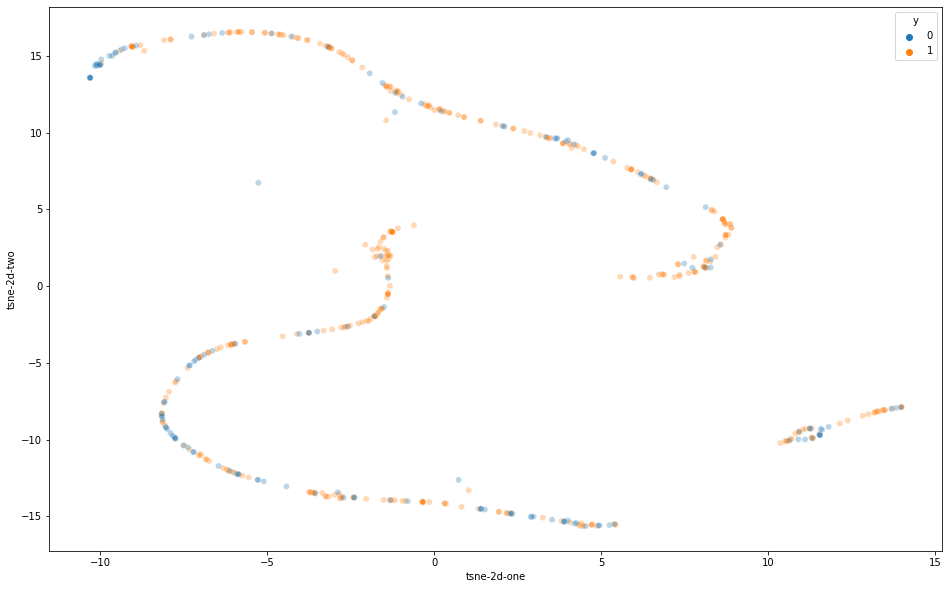

In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

d2=pd.DataFrame(data=x)
#d2.insert(100, "100", output, True) 
#print(d2)
df_subset=pd.DataFrame()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(d2)
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset["y"]=y
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    data=df_subset,
    legend="full",
    alpha=0.3
)
#plt.savefig("tsne_lig_feats.png")

In [ ]:
os.chdir('/content/gdrive/My Drive/prot')
dik=np.load("sm_w2v2.pkl",allow_pickle=True)#use this for best
xnew=[]
ynew=[]
for i,num in enumerate(dik):
  dik[i][1]=dik[i][1].reshape((1,dik[i][1].shape[0]*dik[i][1].shape[1]))
  temp=np.hstack([x[i].reshape((1,100)),dik[i][1]])
  ynew.append(y[i])
  #if dik[i][0] not in ll:
  xnew.append(temp.reshape((temp.shape[1])))

In [ ]:
x=np.asarray(xnew)
y=np.asarray(ynew)
print("f1",np.mean(cross_val_score(model, x, y,scoring="f1_macro",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("f1",np.mean(cross_val_score(model, x, y,scoring="f1",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("precision",np.mean(cross_val_score(model, x, y,scoring="precision",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("accuracy",np.mean(cross_val_score(model, x, y,scoring="accuracy",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("accuracy",(cross_val_score(model, x, y,scoring="accuracy",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))
print("roc_auc",np.mean(cross_val_score(model, x, y,scoring="roc_auc",cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=0))))

f1 0.5836709039286925
f1 0.8623965733533273
precision 0.8264153881067337
accuracy 0.7710459183673469
accuracy [0.79591837 0.73469388 0.85714286 0.69387755 0.73469388 0.81632653
 0.71428571 0.7755102  0.7755102  0.8125    ]
roc_auc 0.6000712250712251


# TEWSST

In [ ]:
with open('x_val.npy', 'rb') as f:
  X_val = np.load(f)
  f.close()
output = nn.Conv1d(2000, 3000, 3, padding=1)
inp = output(torch.tensor(X_val[:32]).float())
output = nn.MaxPool1d(2, stride=1)
inp = output(inp)
output = nn.Conv1d(3000, 6000, 3, padding=1)
print(inp.shape)
inp = output(inp)
output = nn.MaxPool1d(2, stride=1)
inp = output(inp)
print(inp.shape)
output = nn.Conv1d(6000, 7000, 3, padding=1)
inp = output(inp)
output = nn.MaxPool1d(2, stride=1)
inp = output(inp)
print(inp.shape)
output = nn.Conv1d(7000, 14000, 3, padding=1)
inp = output(inp)
output = nn.MaxPool1d(2, stride=1)
inp = output(inp)
print(inp.shape)
output = nn.Conv1d(14000, 15000, 3, padding=1)
inp = output(inp)
output = nn.MaxPool1d(2, stride=1)
output = output(inp)
print(output.shape)
inp = nn.ReLU()
output = inp(output)
inp = nn.Linear(1*100,11)
output = inp(output)

torch.Size([32, 3000, 5])
torch.Size([32, 6000, 4])
torch.Size([32, 7000, 3])
torch.Size([32, 14000, 2])
torch.Size([32, 15000, 1])


RuntimeError: ignored

In [ ]:
output.shape

torch.Size([14590, 100, 1])

In [ ]:
with open('x_val.npy', 'rb') as f:
  X_val = np.load(f)
  f.close()

In [ ]:
output = nn.Conv1d(2000, 1000, 3,padding = 1)
inp = output(torch.tensor(X_val).float())
output = nn.MaxPool1d(2,stride=1)
print(inp.shape)
inp = output(inp)
inp.shape

torch.Size([14590, 1000, 6])


torch.Size([14590, 1000, 5])

In [ ]:
output = nn.Conv1d(1000, 500, 1)
inp = output(inp)
print(inp.shape)
output = nn.MaxPool1d(1)
print(inp.shape)
inp = output(inp)

torch.Size([14590, 500, 2])
torch.Size([14590, 500, 2])


In [ ]:

import torchvision
model = torchvision.models.vgg13(pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg13', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg13_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

In [ ]:
()